In [1]:
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import warnings
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import optuna
from optuna import Trial

SEED = 42
n_splits = 5
common_path = '/kaggle/input/child-mind-institute-problematic-internet-use'

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

def process_file(filename, dirname):
    try:
        df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
        df.drop('step', axis=1, inplace=True)
        return df.describe().values.reshape(-1), filename.split('=')[1]
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        return None, None

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*[res for res in results if res[0] is not None])
    
    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

def update_categorical_columns(df, cat_columns):
    for col in cat_columns:
        df[col] = df[col].fillna('Missing').astype('category')
    return df

def create_mapping(column, train, test):
    combined_data = pd.concat([train[column], test[column]], axis=0)
    unique_values = combined_data.unique()
    return {value: idx for idx, value in enumerate(unique_values)}

def apply_mapping(df, mapping, column):
    df[column] = df[column].replace(mapping).astype(int)
    return df

def drop_null_and_constant_columns(train, test):
    null_columns_train = train.columns[train.isnull().all()].tolist()
    constant_columns_train = [col for col in train.columns if train[col].nunique() <= 1]
    
    columns_to_drop = list(set(null_columns_train + constant_columns_train))
    
    train_reduced = train.drop(columns=columns_to_drop)
    test_reduced = test.drop(columns=columns_to_drop)
    
    print(f"Removed columns: {columns_to_drop}")
    return train_reduced, test_reduced, columns_to_drop


# Applying Operations now
train = pd.read_csv(os.path.join(common_path,'train.csv'))
test = pd.read_csv(os.path.join(common_path,'test.csv'))
sample = pd.read_csv(os.path.join(common_path,'sample_submission.csv'))

train_ts = load_time_series(os.path.join(common_path,'series_train.parquet'))
test_ts = load_time_series(os.path.join(common_path,'series_test.parquet'))

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# List of columns
featuresCols_train = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                      'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                      'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                      'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                      'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                      'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                      'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                      'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                      'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                      'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                      'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                      'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                      'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                      'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                      'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                      'PreInt_EduHx-computerinternet_hoursday', 'sii'] + time_series_cols

featuresCols_test = [col for col in featuresCols_train if col != 'sii']

train = train[featuresCols_train]
test = test[featuresCols_test]

cat_columns = ['Basic_Demos-Enroll_Season', 'CGAS-Season',
               'Physical-Season', 'Fitness_Endurance-Season', 
               'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
               'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

train = update_categorical_columns(train, cat_columns)
test = update_categorical_columns(test, cat_columns)

for col in cat_columns:
    mapping = create_mapping(col, train, test)
    train = apply_mapping(train, mapping, col)
    test = apply_mapping(test, mapping, col)

train, test, removed_columns = drop_null_and_constant_columns(train, test)

print(f'Train Shape: {train.shape} || Test Shape: {test.shape}')


100%|██████████| 2/2 [00:00<00:00,  7.93it/s]

Removed columns: ['Stat_42', 'Stat_41']
Train Shape: (3960, 153) || Test Shape: (20, 152)


<Figure size 1200x800 with 0 Axes>

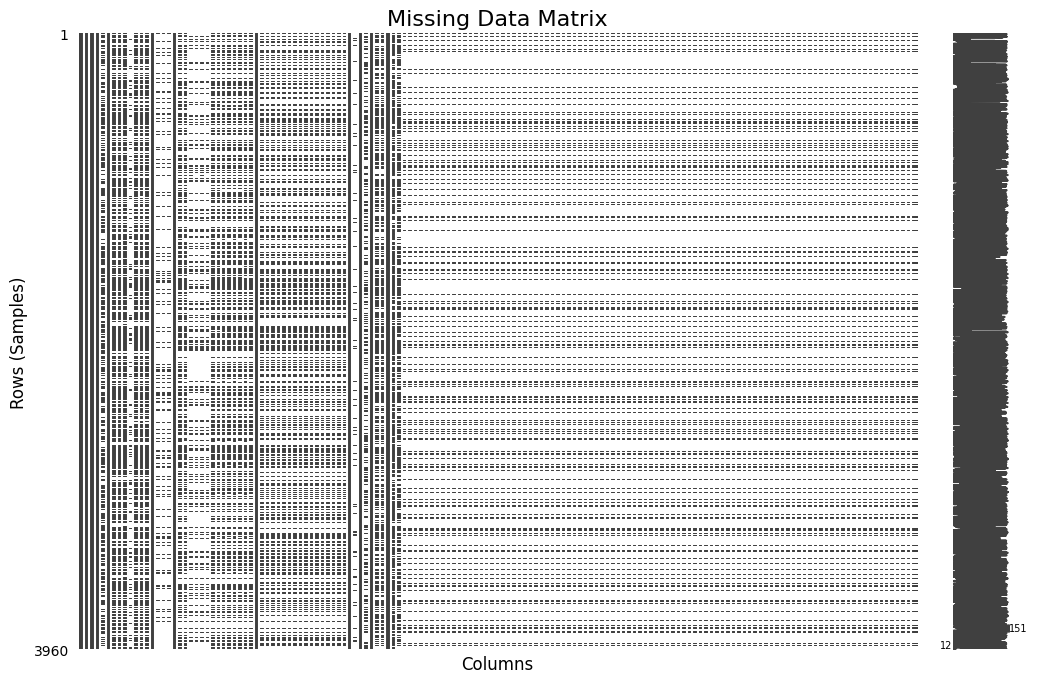

In [2]:
plt.figure(figsize=(12, 8))
msno.matrix(train, figsize=(12, 8), fontsize=8)
plt.title('Missing Data Matrix', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows (Samples)', fontsize=12)
plt.show()

In [3]:
missing_sii_records = train[train['sii'].isnull()]
available_sii_records = train[train['sii'].notnull()]

In [4]:
# SEED = 42
# n_splits = 5

# def quadratic_weighted_kappa(y_true, y_pred):
#     """
#     Calculates the quadratic weighted kappa score between true and predicted values.
    
#     Quadratic weighted kappa measures the agreement between two sets of ordinal labels 
#     by penalizing larger disagreements more heavily.

#     Parameters:
#     y_true (array-like): Ground truth (correct) target values.
#     y_pred (array-like): Predicted target values.

#     Returns:
#     float: The quadratic weighted kappa score.
#     """
#     return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# def threshold_Rounder(oof_non_rounded, thresholds):
#     """
#     Rounds the predicted values based on the provided threshold values.
    
#     This function applies thresholds to convert continuous model predictions 
#     into discrete class labels. It uses the given thresholds to assign class labels 
#     to each prediction based on its value.

#     Parameters:
#     oof_non_rounded (array-like): Continuous predictions made by the model.
#     thresholds (array-like): Thresholds for rounding the predictions into class labels.

#     Returns:
#     array-like: Rounded class labels.
#     """
#     return np.where(oof_non_rounded < thresholds[0], 0,
#                     np.where(oof_non_rounded < thresholds[1], 1,
#                              np.where(oof_non_rounded < thresholds[2], 2, 3)))

# def evaluate_predictions(thresholds, y_true, oof_non_rounded):
#     """
#     Evaluates the model predictions by rounding them using the provided thresholds 
#     and computing the negative quadratic weighted kappa score.
    
#     This function is typically used as a part of an optimization process 
#     (like `scipy.optimize.minimize`) to find the best thresholds that maximize the QWK score.

#     Parameters:
#     thresholds (array-like): Thresholds for rounding predictions into class labels.
#     y_true (array-like): Ground truth (correct) target values.
#     oof_non_rounded (array-like): Continuous predictions made by the model.

#     Returns:
#     float: Negative quadratic weighted kappa score (for minimization purposes).
#     """
#     rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
#     return -quadratic_weighted_kappa(y_true, rounded_p)

# def TrainML(model_class, X_train, y_train, X_test):
#     """
#     Trains a model using Stratified K-Fold cross-validation and returns the final predictions.
    
#     This function trains a given machine learning model using stratified K-fold cross-validation.
#     It evaluates the model on each fold and calculates the quadratic weighted kappa score 
#     for both training and validation sets. The function also optimizes the rounding thresholds 
#     to improve the kappa score and returns the final predictions.

#     Parameters:
#     model_class (estimator): A scikit-learn compatible machine learning model (e.g., LightGBM, CatBoost).
#     X_train (pd.DataFrame or np.ndarray): Training feature set.
#     y_train (pd.Series or np.ndarray): Target variable for training.
#     X_test (pd.DataFrame or np.ndarray): Test feature set for final predictions.

#     Returns:
#     np.ndarray: Tuned predictions for the test set.
#     estimator: The trained machine learning model.
#     """
#     SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
#     oof_non_rounded = np.zeros(len(y_train), dtype=float)
#     oof_rounded = np.zeros(len(y_train), dtype=int)
#     test_preds = np.zeros((len(X_test), n_splits))
    
#     for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X_train, y_train), desc="Training Folds", total=n_splits)):
#         X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

#         model = model_class
#         model.fit(X_tr, y_tr)

#         y_train_pred = model.predict(X_tr)
#         y_val_pred = model.predict(X_val)
        
#         oof_non_rounded[val_idx] = y_val_pred
#         oof_rounded[val_idx] = y_val_pred.round(0).astype(int)
#         test_preds[:, fold] = model.predict(X_test)

#         train_kappa = quadratic_weighted_kappa(y_tr, y_train_pred.round(0).astype(int))
#         val_kappa = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype(int))

#         print(f"Fold {fold + 1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

#     KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), method='Nelder-Mead')
#     assert KappaOPtimizer.success, "Optimization did not converge."

#     tpm = test_preds.mean(axis=1)
#     tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

#     return tpTuned, model

# # Function to plot feature importance
# def plot_feature_importance(model, top_n=100):
#     """
#     Plots the top `top_n` feature importances for the trained LightGBM model.
    
#     Parameters:
#     model (LightGBM model): The trained LightGBM model.
#     top_n (int): Number of top important features to display.
#     """
#     feature_importance_df = pd.DataFrame({
#         'Feature': model.booster_.feature_name(),
#         'Importance': model.booster_.feature_importance(importance_type='gain')
#     })

#     feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#     plt.figure(figsize=(10, top_n / 2))  # Adjusting height to accommodate top N features
#     sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n)) 
#     plt.title(f"Top {top_n} Feature Importance")
#     plt.xlabel("Importance")
#     plt.ylabel("Feature")
#     plt.show()

# # Create a function to allow supervised or semi-supervised learning and plot feature importance
# def supervised_or_semi_supervised(approach='semi-supervised', model_params=None, top_n=100):
#     """
#     This function allows you to approach the task using supervised or semi-supervised learning,
#     and then plots the feature importance.

#     Parameters:
#     approach (str): "supervised" or "semi-supervised". Default is "semi-supervised".
#     model_params (dict): Parameters for the LightGBM model.
#     top_n (int): Number of top important features to display in the feature importance plot.
    
#     Returns:
#     None: Trains the model, plots feature importance, and creates a submission file.
#     """
#     # Default LightGBM model parameters if none are provided
#     if model_params is None:
#         model_params = {
#             'learning_rate': 0.03884249148676395, 
#             'max_depth': 12, 
#             'num_leaves': 413, 
#             'min_data_in_leaf': 14,
#             'feature_fraction': 0.7987976913702801, 
#             'bagging_fraction': 0.7602261703576205, 
#             'bagging_freq': 2, 
#             'lambda_l1': 4.735462555910575, 
#             'lambda_l2': 4.735028557007343e-06,
#             'n_estimators': 200,
#             'random_state': SEED,
#             'verbose': -1
#         }
    
#     Light = lgb.LGBMRegressor(**model_params)

#     # Step 1: Split the available and missing sii records
#     available_sii_records = train[train['sii'].notnull()].copy()
#     missing_sii_records = train[train['sii'].isnull()].copy()

#     X_train_avail = available_sii_records.drop('sii', axis=1)
#     y_train_avail = available_sii_records['sii']

#     # Semi-Supervised Approach
#     if approach == 'semi-supervised' and len(missing_sii_records) > 0:
#         print("Proceeding with Semi-Supervised Learning...")
        
#         # Step 2: Train model on available sii data and predict missing sii values
#         X_train_missing = missing_sii_records.drop('sii', axis=1)
#         predicted_sii_for_missing, _ = TrainML(Light, X_train_avail, y_train_avail, X_train_missing)

#         # Step 3: Combine the predicted `sii` records with the available records
#         missing_sii_records['sii'] = predicted_sii_for_missing
#         combined_train = pd.concat([available_sii_records, missing_sii_records], axis=0)

#         X_train_combined = combined_train.drop('sii', axis=1)
#         y_train_combined = combined_train['sii']

#         # Step 4: Retrain the model on the combined dataset
#         final_preds, final_model = TrainML(Light, X_train_combined, y_train_combined, test)
    
#     # Supervised Approach
#     else:
#         print("Proceeding with Supervised Learning...")
        
#         # Step 2: Proceed with supervised learning on the available `sii` data
#         final_preds, final_model = TrainML(Light, X_train_avail, y_train_avail, test)

#     # Step 5: Plot feature importance
#     print(f"Plotting top {top_n} features by importance...")
#     plot_feature_importance(final_model, top_n=top_n)

#     # Step 6: Prepare the submission
#     submission = pd.DataFrame({
#         'id': sample['id'],
#         'sii': final_preds
#     })
    
#     return submission

In [5]:
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculates the quadratic weighted kappa score between the true and predicted values.

    Args:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.

    Returns:
    float: Quadratic weighted kappa score.
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    """
    Rounds the predicted values based on the specified thresholds.

    Args:
    oof_non_rounded (array-like): Unrounded predicted values.
    thresholds (list): List of threshold values for rounding.

    Returns:
    array: Rounded predicted values based on the thresholds.
    """
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    """
    Evaluates the model predictions by calculating the negative quadratic weighted kappa score.

    Args:
    thresholds (list): List of threshold values for rounding.
    y_true (array-like): True target values.
    oof_non_rounded (array-like): Unrounded predicted values.

    Returns:
    float: Negative quadratic weighted kappa score.
    """
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, X_train, y_train, X_test, model_name=""):
    """
    Trains a machine learning model using stratified K-fold cross-validation and returns predictions.

    Args:
    model_class: Model class to train.
    X_train (DataFrame): Training features.
    y_train (Series): Training target.
    X_test (DataFrame): Test features for prediction.
    model_name (str, optional): Name of the model being trained (for logging purposes). Default is "".

    Returns:
    tuple: Predicted values for the test set, trained model, and average validation QWK score.
    """
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    oof_non_rounded = np.zeros(len(y_train), dtype=float)
    test_preds = np.zeros((len(X_test), n_splits))
    val_scores = []  # Store validation QWK scores for each fold

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X_train, y_train), desc=f"Training Folds for {model_name}", total=n_splits)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = model_class
        model.fit(X_tr, y_tr)

        y_val_pred = model.predict(X_val)
        
        oof_non_rounded[val_idx] = y_val_pred
        test_preds[:, fold] = model.predict(X_test)

        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred.round(0).astype(int))
        val_scores.append(val_kappa)  # Store validation QWK score

        print(f"Fold {fold + 1} - Validation QWK: {val_kappa:.4f}")

    avg_val_score = np.mean(val_scores)  # Average validation QWK score across folds
    print(f"Average Validation QWK for {model_name}: {avg_val_score:.4f}")

    # Threshold optimization and test predictions
    KappaOPtimizer = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5], args=(y_train, oof_non_rounded), method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    return tpTuned, model, avg_val_score

def objective(trial: Trial, model_type, X_train, y_train):
    """
    Defines the hyperparameter optimization objective for Optuna based on Validation QWK score.

    Args:
    trial (optuna.Trial): A trial instance for Optuna.
    model_type (str): Type of the model to optimize ('lightgbm' or 'xgboost').
    X_train (DataFrame): Training features.
    y_train (Series): Training target.

    Returns:
    float: Average validation QWK score for the trial.
    """
    if model_type == 'lightgbm':
        params = {
            'objective': trial.suggest_categorical('objective', ['poisson', 'tweedie', 'regression']),
            'random_state': SEED,
            'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        if params['objective'] == 'tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = lgb.LGBMRegressor(**params)

    elif model_type == 'xgboost':
        params = {
            'objective': trial.suggest_categorical('objective', ['reg:squarederror', 'reg:tweedie', 'reg:pseudohubererror']),
            'random_state': SEED,
            'n_estimators': trial.suggest_int('n_estimators', 300, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.02, 0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e-1),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e-1)
        }
        if params['objective'] == 'reg:tweedie':
            params['tweedie_variance_power'] = trial.suggest_float('tweedie_variance_power', 1, 2)
        model = xgb.XGBRegressor(**params, use_label_encoder=False)

    # Train the model and return the validation QWK score
    _, _, avg_val_score = TrainML(model, X_train, y_train, X_train, model_type)
    return avg_val_score  # Optuna will optimize based on Validation QWK score

def run_optuna_tuning(X_train, y_train, model_type, n_trials=50):
    """
    Runs hyperparameter tuning for a given model using Optuna.

    Args:
    X_train (DataFrame): Training features.
    y_train (Series): Training target.
    model_type (str): Model type ('lightgbm' or 'xgboost') to tune.
    n_trials (int): Number of Optuna trials.

    Returns:
    dict: Best hyperparameters found during tuning.
    """
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_type, X_train, y_train), n_trials=n_trials)
    
    print(f"Best hyperparameters for {model_type}: {study.best_params}")
    return study.best_params

def compare_models(X_train, y_train, X_test):
    """
    Compares LightGBM and XGBoost models by tuning their hyperparameters and selecting the best model based on Validation QWK score.

    Args:
    X_train (DataFrame): Training features.
    y_train (Series): Training target.
    X_test (DataFrame): Test features.

    Returns:
    tuple: Best model and its parameters based on Validation QWK score.
    """
    # Tune and evaluate each model
    print("Tuning and evaluating LightGBM...")
    lgb_params = run_optuna_tuning(X_train, y_train, 'lightgbm')
    _, lgb_model, lgb_val_score = TrainML(lgb.LGBMRegressor(**lgb_params), X_train, y_train, X_test, 'lightgbm')
    
    print("Tuning and evaluating XGBoost...")
    xgb_params = run_optuna_tuning(X_train, y_train, 'xgboost')
    _, xgb_model, xgb_val_score = TrainML(xgb.XGBRegressor(**xgb_params), X_train, y_train, X_test, 'xgboost')

    # Select the best model based on average validation score
    if lgb_val_score > xgb_val_score:
        print(f"LightGBM has the best validation score: {lgb_val_score:.4f}")
        return lgb_model, lgb_params
    else:
        print(f"XGBoost has the best validation score: {xgb_val_score:.4f}")
        return xgb_model, xgb_params

def supervised_or_semi_supervised(approach='semi-supervised'):
    """
    Performs supervised or semi-supervised learning based on the chosen approach, tunes multiple models, and returns predictions.

    Args:
    approach (str): Learning approach ('semi-supervised' or 'supervised'). Default is 'semi-supervised'.

    Returns:
    DataFrame: Submission DataFrame with predictions for the test set.
    """
    # Step 1: Split the available and missing sii records
    available_sii_records = train[train['sii'].notnull()].copy()
    missing_sii_records = train[train['sii'].isnull()].copy()

    X_train_avail = available_sii_records.drop('sii', axis=1)
    y_train_avail = available_sii_records['sii']
    X_test = test.copy()  # Test data doesn't have 'sii' column, so no need to drop

    if approach == 'semi-supervised' and len(missing_sii_records) > 0:
        print("Proceeding with Semi-Supervised Learning...")

        # Step 2: Train model on available sii data and predict missing sii values
        X_train_missing = missing_sii_records.drop('sii', axis=1)
        predicted_sii_for_missing, _, _ = TrainML(lgb.LGBMRegressor(**lgb_starting_params), X_train_avail, y_train_avail, X_train_missing)

        # Step 3: Combine the predicted `sii` records with the available records
        missing_sii_records['sii'] = predicted_sii_for_missing
        combined_train = pd.concat([available_sii_records, missing_sii_records], axis=0)

        X_train_combined = combined_train.drop('sii', axis=1)
        y_train_combined = combined_train['sii']

        # Step 4: Run model comparison on combined data
        best_model, best_params = compare_models(X_train_combined, y_train_combined, X_test)
    
    else:
        print("Proceeding with Supervised Learning...")
        
        # Step 5: Run model comparison on available data only
        best_model, best_params = compare_models(X_train_avail, y_train_avail, X_test)

    # Train the final best model, capture only the predictions and model
    final_preds, final_model, _ = TrainML(best_model, X_train_avail, y_train_avail, X_test)

    # Step 6: Prepare the submission
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': final_preds
    })

    # Save the submission
    return submission

In [6]:
submission = supervised_or_semi_supervised(approach='supervised')
# submission = supervised_or_semi_supervised(approach='semi-supervised') 

submission.to_csv('submission.csv', index=False)

[I 2024-10-05 09:19:08,872] A new study created in memory with name: no-name-2e28bf4e-3cb6-4921-9e30-3ce9823e5b2a


Proceeding with Supervised Learning...
Tuning and evaluating LightGBM...


Training Folds for lightgbm:  20%|██        | 1/5 [00:01<00:06,  1.62s/it]

Fold 1 - Validation QWK: 0.3742


Training Folds for lightgbm:  40%|████      | 2/5 [00:03<00:04,  1.57s/it]

Fold 2 - Validation QWK: 0.4396


Training Folds for lightgbm:  60%|██████    | 3/5 [00:04<00:03,  1.58s/it]

Fold 3 - Validation QWK: 0.3738


Training Folds for lightgbm:  80%|████████  | 4/5 [00:06<00:01,  1.59s/it]

Fold 4 - Validation QWK: 0.3757


Training Folds for lightgbm: 100%|██████████| 5/5 [00:07<00:00,  1.60s/it]

Fold 5 - Validation QWK: 0.3661
Average Validation QWK for lightgbm: 0.3859



[I 2024-10-05 09:19:17,379] Trial 0 finished with value: 0.38588386498520844 and parameters: {'objective': 'poisson', 'n_estimators': 119, 'max_depth': 7, 'learning_rate': 0.05151060650011312, 'subsample': 0.9385485713387098, 'colsample_bytree': 0.6905296551589906}. Best is trial 0 with value: 0.38588386498520844.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:20,  5.14s/it]

Fold 1 - Validation QWK: 0.3996


Training Folds for lightgbm:  40%|████      | 2/5 [00:10<00:15,  5.18s/it]

Fold 2 - Validation QWK: 0.4626


Training Folds for lightgbm:  60%|██████    | 3/5 [00:15<00:10,  5.22s/it]

Fold 3 - Validation QWK: 0.3897


Training Folds for lightgbm:  80%|████████  | 4/5 [00:21<00:05,  5.50s/it]

Fold 4 - Validation QWK: 0.3910


Training Folds for lightgbm: 100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

Fold 5 - Validation QWK: 0.3559
Average Validation QWK for lightgbm: 0.3998



[I 2024-10-05 09:19:44,830] Trial 1 finished with value: 0.39976703748156606 and parameters: {'objective': 'poisson', 'n_estimators': 378, 'max_depth': 7, 'learning_rate': 0.025552998459582577, 'subsample': 0.7950346421859096, 'colsample_bytree': 0.8635343276714815}. Best is trial 1 with value: 0.39976703748156606.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:10,  2.64s/it]

Fold 1 - Validation QWK: 0.3868


Training Folds for lightgbm:  40%|████      | 2/5 [00:05<00:08,  2.70s/it]

Fold 2 - Validation QWK: 0.4515


Training Folds for lightgbm:  60%|██████    | 3/5 [00:08<00:05,  2.74s/it]

Fold 3 - Validation QWK: 0.4216


Training Folds for lightgbm:  80%|████████  | 4/5 [00:11<00:02,  2.78s/it]

Fold 4 - Validation QWK: 0.3502


Training Folds for lightgbm: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

Fold 5 - Validation QWK: 0.3266
Average Validation QWK for lightgbm: 0.3874



[I 2024-10-05 09:19:59,112] Trial 2 finished with value: 0.3873501685845776 and parameters: {'objective': 'tweedie', 'n_estimators': 502, 'max_depth': 5, 'learning_rate': 0.023775038045185742, 'subsample': 0.9587122753950641, 'colsample_bytree': 0.558051316424052, 'tweedie_variance_power': 1.3503757108773575}. Best is trial 1 with value: 0.39976703748156606.
Training Folds for lightgbm:  20%|██        | 1/5 [00:01<00:05,  1.43s/it]

Fold 1 - Validation QWK: 0.3429


Training Folds for lightgbm:  40%|████      | 2/5 [00:02<00:04,  1.48s/it]

Fold 2 - Validation QWK: 0.4266


Training Folds for lightgbm:  60%|██████    | 3/5 [00:04<00:03,  1.51s/it]

Fold 3 - Validation QWK: 0.4186


Training Folds for lightgbm:  80%|████████  | 4/5 [00:05<00:01,  1.50s/it]

Fold 4 - Validation QWK: 0.3154


Training Folds for lightgbm: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

Fold 5 - Validation QWK: 0.3562
Average Validation QWK for lightgbm: 0.3719



[I 2024-10-05 09:20:07,200] Trial 3 finished with value: 0.3719304269799164 and parameters: {'objective': 'regression', 'n_estimators': 184, 'max_depth': 6, 'learning_rate': 0.03458588467263702, 'subsample': 0.8810103977491278, 'colsample_bytree': 0.6268742941322669}. Best is trial 1 with value: 0.39976703748156606.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:12,  3.20s/it]

Fold 1 - Validation QWK: 0.4375


Training Folds for lightgbm:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

Fold 2 - Validation QWK: 0.4568


Training Folds for lightgbm:  60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

Fold 3 - Validation QWK: 0.3927


Training Folds for lightgbm:  80%|████████  | 4/5 [00:13<00:03,  3.32s/it]

Fold 4 - Validation QWK: 0.3759


Training Folds for lightgbm: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

Fold 5 - Validation QWK: 0.3380
Average Validation QWK for lightgbm: 0.4002



[I 2024-10-05 09:20:24,251] Trial 4 finished with value: 0.40019308464182285 and parameters: {'objective': 'poisson', 'n_estimators': 236, 'max_depth': 9, 'learning_rate': 0.06386873705117666, 'subsample': 0.7630096712929852, 'colsample_bytree': 0.8432241159176672}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:01<00:05,  1.48s/it]

Fold 1 - Validation QWK: 0.3463


Training Folds for lightgbm:  40%|████      | 2/5 [00:02<00:04,  1.49s/it]

Fold 2 - Validation QWK: 0.4124


Training Folds for lightgbm:  60%|██████    | 3/5 [00:04<00:03,  1.51s/it]

Fold 3 - Validation QWK: 0.4060


Training Folds for lightgbm:  80%|████████  | 4/5 [00:06<00:01,  1.51s/it]

Fold 4 - Validation QWK: 0.3315


Training Folds for lightgbm: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

Fold 5 - Validation QWK: 0.3553
Average Validation QWK for lightgbm: 0.3703



[I 2024-10-05 09:20:32,241] Trial 5 finished with value: 0.3703043652690203 and parameters: {'objective': 'regression', 'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.018157262736205465, 'subsample': 0.6992144625297756, 'colsample_bytree': 0.6844289694065466}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:08,  2.15s/it]

Fold 1 - Validation QWK: 0.3713


Training Folds for lightgbm:  40%|████      | 2/5 [00:04<00:06,  2.14s/it]

Fold 2 - Validation QWK: 0.4088


Training Folds for lightgbm:  60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

Fold 3 - Validation QWK: 0.3900


Training Folds for lightgbm:  80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

Fold 4 - Validation QWK: 0.3250


Training Folds for lightgbm: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]

Fold 5 - Validation QWK: 0.3137
Average Validation QWK for lightgbm: 0.3617



[I 2024-10-05 09:20:43,611] Trial 6 finished with value: 0.3617458441760167 and parameters: {'objective': 'poisson', 'n_estimators': 209, 'max_depth': 9, 'learning_rate': 0.16793820180234734, 'subsample': 0.9626054437578881, 'colsample_bytree': 0.6612384572957399}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:17,  4.30s/it]

Fold 1 - Validation QWK: 0.4154


Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:13,  4.36s/it]

Fold 2 - Validation QWK: 0.4573


Training Folds for lightgbm:  60%|██████    | 3/5 [00:13<00:08,  4.45s/it]

Fold 3 - Validation QWK: 0.3995


Training Folds for lightgbm:  80%|████████  | 4/5 [00:17<00:04,  4.48s/it]

Fold 4 - Validation QWK: 0.3807


Training Folds for lightgbm: 100%|██████████| 5/5 [00:22<00:00,  4.46s/it]

Fold 5 - Validation QWK: 0.3385
Average Validation QWK for lightgbm: 0.3983



[I 2024-10-05 09:21:06,396] Trial 7 finished with value: 0.3982751694198652 and parameters: {'objective': 'tweedie', 'n_estimators': 344, 'max_depth': 9, 'learning_rate': 0.014158053140002897, 'subsample': 0.5424311776742583, 'colsample_bytree': 0.6996618474908891, 'tweedie_variance_power': 1.1168807646491752}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:20,  5.04s/it]

Fold 1 - Validation QWK: 0.3807


Training Folds for lightgbm:  40%|████      | 2/5 [00:10<00:15,  5.06s/it]

Fold 2 - Validation QWK: 0.3896


Training Folds for lightgbm:  60%|██████    | 3/5 [00:15<00:10,  5.08s/it]

Fold 3 - Validation QWK: 0.3721


Training Folds for lightgbm:  80%|████████  | 4/5 [00:21<00:05,  5.45s/it]

Fold 4 - Validation QWK: 0.3326


Training Folds for lightgbm: 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

Fold 5 - Validation QWK: 0.3175
Average Validation QWK for lightgbm: 0.3585



[I 2024-10-05 09:21:34,715] Trial 8 finished with value: 0.3585190069573526 and parameters: {'objective': 'regression', 'n_estimators': 545, 'max_depth': 7, 'learning_rate': 0.11021692495784088, 'subsample': 0.7847022072972512, 'colsample_bytree': 0.7830983671541208}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:10<00:41, 10.35s/it]

Fold 1 - Validation QWK: 0.3235


Training Folds for lightgbm:  40%|████      | 2/5 [00:17<00:24,  8.30s/it]

Fold 2 - Validation QWK: 0.3766


Training Folds for lightgbm:  60%|██████    | 3/5 [00:24<00:15,  7.61s/it]

Fold 3 - Validation QWK: 0.3610


Training Folds for lightgbm:  80%|████████  | 4/5 [00:30<00:07,  7.29s/it]

Fold 4 - Validation QWK: 0.2913


Training Folds for lightgbm: 100%|██████████| 5/5 [00:37<00:00,  7.48s/it]

Fold 5 - Validation QWK: 0.2836
Average Validation QWK for lightgbm: 0.3272



[I 2024-10-05 09:22:12,515] Trial 9 finished with value: 0.3272026541751341 and parameters: {'objective': 'poisson', 'n_estimators': 508, 'max_depth': 10, 'learning_rate': 0.09283375130640999, 'subsample': 0.8539264084596382, 'colsample_bytree': 0.8681621542474158}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:01<00:07,  1.85s/it]

Fold 1 - Validation QWK: 0.3293


Training Folds for lightgbm:  40%|████      | 2/5 [00:03<00:05,  1.87s/it]

Fold 2 - Validation QWK: 0.4304


Training Folds for lightgbm:  60%|██████    | 3/5 [00:05<00:03,  1.87s/it]

Fold 3 - Validation QWK: 0.4225


Training Folds for lightgbm:  80%|████████  | 4/5 [00:07<00:01,  1.86s/it]

Fold 4 - Validation QWK: 0.3729


Training Folds for lightgbm: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it]

Fold 5 - Validation QWK: 0.3541
Average Validation QWK for lightgbm: 0.3819



[I 2024-10-05 09:22:22,424] Trial 10 finished with value: 0.3818596996027213 and parameters: {'objective': 'poisson', 'n_estimators': 391, 'max_depth': 3, 'learning_rate': 0.29044368306175394, 'subsample': 0.6400858640919077, 'colsample_bytree': 0.997728068254878}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:19,  4.89s/it]

Fold 1 - Validation QWK: 0.4200


Training Folds for lightgbm:  40%|████      | 2/5 [00:09<00:14,  4.98s/it]

Fold 2 - Validation QWK: 0.4292


Training Folds for lightgbm:  60%|██████    | 3/5 [00:15<00:10,  5.02s/it]

Fold 3 - Validation QWK: 0.4051


Training Folds for lightgbm:  80%|████████  | 4/5 [00:19<00:05,  5.01s/it]

Fold 4 - Validation QWK: 0.3603


Training Folds for lightgbm: 100%|██████████| 5/5 [00:25<00:00,  5.01s/it]

Fold 5 - Validation QWK: 0.3444
Average Validation QWK for lightgbm: 0.3918



[I 2024-10-05 09:22:48,005] Trial 11 finished with value: 0.3917961463620524 and parameters: {'objective': 'poisson', 'n_estimators': 389, 'max_depth': 8, 'learning_rate': 0.04369388826744602, 'subsample': 0.7743770111488762, 'colsample_bytree': 0.8561358599472879}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:15,  4.00s/it]

Fold 1 - Validation QWK: 0.3940


Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:12,  4.03s/it]

Fold 2 - Validation QWK: 0.4283


Training Folds for lightgbm:  60%|██████    | 3/5 [00:12<00:08,  4.06s/it]

Fold 3 - Validation QWK: 0.4146


Training Folds for lightgbm:  80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Fold 4 - Validation QWK: 0.3607


Training Folds for lightgbm: 100%|██████████| 5/5 [00:20<00:00,  4.07s/it]

Fold 5 - Validation QWK: 0.2912
Average Validation QWK for lightgbm: 0.3777



[I 2024-10-05 09:23:09,007] Trial 12 finished with value: 0.3777471341572042 and parameters: {'objective': 'poisson', 'n_estimators': 269, 'max_depth': 10, 'learning_rate': 0.07830040366824614, 'subsample': 0.6949028199684146, 'colsample_bytree': 0.9362401333387245}. Best is trial 4 with value: 0.40019308464182285.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:22,  5.62s/it]

Fold 1 - Validation QWK: 0.4173


Training Folds for lightgbm:  40%|████      | 2/5 [00:11<00:17,  5.73s/it]

Fold 2 - Validation QWK: 0.4721


Training Folds for lightgbm:  60%|██████    | 3/5 [00:17<00:11,  5.76s/it]

Fold 3 - Validation QWK: 0.3939


Training Folds for lightgbm:  80%|████████  | 4/5 [00:23<00:05,  5.77s/it]

Fold 4 - Validation QWK: 0.3848


Training Folds for lightgbm: 100%|██████████| 5/5 [00:28<00:00,  5.73s/it]

Fold 5 - Validation QWK: 0.3422
Average Validation QWK for lightgbm: 0.4021



[I 2024-10-05 09:23:38,272] Trial 13 finished with value: 0.40206753172781473 and parameters: {'objective': 'poisson', 'n_estimators': 436, 'max_depth': 8, 'learning_rate': 0.028913068020287817, 'subsample': 0.8182791598231012, 'colsample_bytree': 0.8038272893515817}. Best is trial 13 with value: 0.40206753172781473.
Training Folds for lightgbm:  20%|██        | 1/5 [00:07<00:29,  7.31s/it]

Fold 1 - Validation QWK: 0.3711


Training Folds for lightgbm:  40%|████      | 2/5 [00:14<00:22,  7.44s/it]

Fold 2 - Validation QWK: 0.4398


Training Folds for lightgbm:  60%|██████    | 3/5 [00:22<00:14,  7.38s/it]

Fold 3 - Validation QWK: 0.3919


Training Folds for lightgbm:  80%|████████  | 4/5 [00:29<00:07,  7.37s/it]

Fold 4 - Validation QWK: 0.3443


Training Folds for lightgbm: 100%|██████████| 5/5 [00:36<00:00,  7.36s/it]

Fold 5 - Validation QWK: 0.3487
Average Validation QWK for lightgbm: 0.3792



[I 2024-10-05 09:24:15,609] Trial 14 finished with value: 0.3791523026108543 and parameters: {'objective': 'poisson', 'n_estimators': 463, 'max_depth': 8, 'learning_rate': 0.010256331995064668, 'subsample': 0.8465326084166522, 'colsample_bytree': 0.7839040150321943}. Best is trial 13 with value: 0.40206753172781473.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:20,  5.13s/it]

Fold 1 - Validation QWK: 0.1755


Training Folds for lightgbm:  40%|████      | 2/5 [00:10<00:15,  5.33s/it]

Fold 2 - Validation QWK: 0.1707


Training Folds for lightgbm:  60%|██████    | 3/5 [00:15<00:10,  5.34s/it]

Fold 3 - Validation QWK: 0.2484


Training Folds for lightgbm:  80%|████████  | 4/5 [00:21<00:05,  5.34s/it]

Fold 4 - Validation QWK: 0.1396


Training Folds for lightgbm: 100%|██████████| 5/5 [00:26<00:00,  5.33s/it]

Fold 5 - Validation QWK: 0.1963
Average Validation QWK for lightgbm: 0.1861



[I 2024-10-05 09:24:42,705] Trial 15 finished with value: 0.18609891933071898 and parameters: {'objective': 'tweedie', 'n_estimators': 441, 'max_depth': 9, 'learning_rate': 0.0627759609542458, 'subsample': 0.6259507351760524, 'colsample_bytree': 0.8085119603697156, 'tweedie_variance_power': 1.9134390837558284}. Best is trial 13 with value: 0.40206753172781473.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:18,  4.72s/it]

Fold 1 - Validation QWK: 0.4320


Training Folds for lightgbm:  40%|████      | 2/5 [00:09<00:14,  4.71s/it]

Fold 2 - Validation QWK: 0.4490


Training Folds for lightgbm:  60%|██████    | 3/5 [00:14<00:09,  4.76s/it]

Fold 3 - Validation QWK: 0.4175


Training Folds for lightgbm:  80%|████████  | 4/5 [00:18<00:04,  4.75s/it]

Fold 4 - Validation QWK: 0.3771


Training Folds for lightgbm: 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]

Fold 5 - Validation QWK: 0.3508
Average Validation QWK for lightgbm: 0.4053



[I 2024-10-05 09:25:06,954] Trial 16 finished with value: 0.4052785198206689 and parameters: {'objective': 'poisson', 'n_estimators': 304, 'max_depth': 8, 'learning_rate': 0.03438312498799236, 'subsample': 0.711170373943002, 'colsample_bytree': 0.9307299929908179}. Best is trial 16 with value: 0.4052785198206689.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:16,  4.00s/it]

Fold 1 - Validation QWK: 0.4150


Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:12,  4.06s/it]

Fold 2 - Validation QWK: 0.4653


Training Folds for lightgbm:  60%|██████    | 3/5 [00:12<00:08,  4.08s/it]

Fold 3 - Validation QWK: 0.4114


Training Folds for lightgbm:  80%|████████  | 4/5 [00:16<00:04,  4.15s/it]

Fold 4 - Validation QWK: 0.3982


Training Folds for lightgbm: 100%|██████████| 5/5 [00:20<00:00,  4.16s/it]

Fold 5 - Validation QWK: 0.3718
Average Validation QWK for lightgbm: 0.4123



[I 2024-10-05 09:25:28,321] Trial 17 finished with value: 0.41232716724624413 and parameters: {'objective': 'poisson', 'n_estimators': 317, 'max_depth': 6, 'learning_rate': 0.030106367353841902, 'subsample': 0.514821510610442, 'colsample_bytree': 0.9239287482996825}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:09,  2.47s/it]

Fold 1 - Validation QWK: 0.3522


Training Folds for lightgbm:  40%|████      | 2/5 [00:05<00:07,  2.53s/it]

Fold 2 - Validation QWK: 0.4191


Training Folds for lightgbm:  60%|██████    | 3/5 [00:07<00:05,  2.51s/it]

Fold 3 - Validation QWK: 0.4183


Training Folds for lightgbm:  80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

Fold 4 - Validation QWK: 0.3298


Training Folds for lightgbm: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]

Fold 5 - Validation QWK: 0.3561
Average Validation QWK for lightgbm: 0.3751



[I 2024-10-05 09:25:41,430] Trial 18 finished with value: 0.37509532449105887 and parameters: {'objective': 'regression', 'n_estimators': 318, 'max_depth': 5, 'learning_rate': 0.04045515631157321, 'subsample': 0.5105901706310134, 'colsample_bytree': 0.9284001522957754}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:09,  2.28s/it]

Fold 1 - Validation QWK: 0.3019


Training Folds for lightgbm:  40%|████      | 2/5 [00:04<00:06,  2.23s/it]

Fold 2 - Validation QWK: 0.3432


Training Folds for lightgbm:  60%|██████    | 3/5 [00:06<00:04,  2.22s/it]

Fold 3 - Validation QWK: 0.3101


Training Folds for lightgbm:  80%|████████  | 4/5 [00:08<00:02,  2.24s/it]

Fold 4 - Validation QWK: 0.3022


Training Folds for lightgbm: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

Fold 5 - Validation QWK: 0.2718
Average Validation QWK for lightgbm: 0.3058



[I 2024-10-05 09:25:53,196] Trial 19 finished with value: 0.3058331998935544 and parameters: {'objective': 'tweedie', 'n_estimators': 151, 'max_depth': 6, 'learning_rate': 0.018600401212647256, 'subsample': 0.5807446071039704, 'colsample_bytree': 0.9974240164756605, 'tweedie_variance_power': 1.9948230376243896}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:08,  2.05s/it]

Fold 1 - Validation QWK: 0.3942


Training Folds for lightgbm:  40%|████      | 2/5 [00:04<00:06,  2.09s/it]

Fold 2 - Validation QWK: 0.4210


Training Folds for lightgbm:  60%|██████    | 3/5 [00:06<00:04,  2.13s/it]

Fold 3 - Validation QWK: 0.4288


Training Folds for lightgbm:  80%|████████  | 4/5 [00:08<00:02,  2.12s/it]

Fold 4 - Validation QWK: 0.3508


Training Folds for lightgbm: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]

Fold 5 - Validation QWK: 0.3223
Average Validation QWK for lightgbm: 0.3834



[I 2024-10-05 09:26:04,394] Trial 20 finished with value: 0.3834258016406021 and parameters: {'objective': 'poisson', 'n_estimators': 261, 'max_depth': 5, 'learning_rate': 0.14915440776573372, 'subsample': 0.7052224107689518, 'colsample_bytree': 0.9263507580252726}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:07<00:31,  7.89s/it]

Fold 1 - Validation QWK: 0.4058


Training Folds for lightgbm:  40%|████      | 2/5 [00:16<00:24,  8.13s/it]

Fold 2 - Validation QWK: 0.4182


Training Folds for lightgbm:  60%|██████    | 3/5 [00:24<00:16,  8.17s/it]

Fold 3 - Validation QWK: 0.3964


Training Folds for lightgbm:  80%|████████  | 4/5 [00:32<00:08,  8.15s/it]

Fold 4 - Validation QWK: 0.3835


Training Folds for lightgbm: 100%|██████████| 5/5 [00:40<00:00,  8.07s/it]

Fold 5 - Validation QWK: 0.3104
Average Validation QWK for lightgbm: 0.3829



[I 2024-10-05 09:26:45,281] Trial 21 finished with value: 0.38285825010749425 and parameters: {'objective': 'poisson', 'n_estimators': 584, 'max_depth': 8, 'learning_rate': 0.02972310881194799, 'subsample': 0.6245079337020983, 'colsample_bytree': 0.9186224476901443}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:23,  5.80s/it]

Fold 1 - Validation QWK: 0.4014


Training Folds for lightgbm:  40%|████      | 2/5 [00:11<00:17,  5.89s/it]

Fold 2 - Validation QWK: 0.4517


Training Folds for lightgbm:  60%|██████    | 3/5 [00:17<00:11,  5.95s/it]

Fold 3 - Validation QWK: 0.3666


Training Folds for lightgbm:  80%|████████  | 4/5 [00:23<00:06,  6.05s/it]

Fold 4 - Validation QWK: 0.3919


Training Folds for lightgbm: 100%|██████████| 5/5 [00:30<00:00,  6.00s/it]

Fold 5 - Validation QWK: 0.3647
Average Validation QWK for lightgbm: 0.3953



[I 2024-10-05 09:27:15,833] Trial 22 finished with value: 0.39527862974658345 and parameters: {'objective': 'poisson', 'n_estimators': 444, 'max_depth': 6, 'learning_rate': 0.020636043484102508, 'subsample': 0.8905969011117227, 'colsample_bytree': 0.9596474388223343}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:19,  4.82s/it]

Fold 1 - Validation QWK: 0.4191


Training Folds for lightgbm:  40%|████      | 2/5 [00:09<00:14,  4.90s/it]

Fold 2 - Validation QWK: 0.4366


Training Folds for lightgbm:  60%|██████    | 3/5 [00:14<00:09,  4.94s/it]

Fold 3 - Validation QWK: 0.4190


Training Folds for lightgbm:  80%|████████  | 4/5 [00:19<00:05,  5.00s/it]

Fold 4 - Validation QWK: 0.3665


Training Folds for lightgbm: 100%|██████████| 5/5 [00:24<00:00,  4.94s/it]

Fold 5 - Validation QWK: 0.3418
Average Validation QWK for lightgbm: 0.3966



[I 2024-10-05 09:27:41,131] Trial 23 finished with value: 0.396587331800041 and parameters: {'objective': 'poisson', 'n_estimators': 327, 'max_depth': 8, 'learning_rate': 0.03331470330501943, 'subsample': 0.821312300787441, 'colsample_bytree': 0.8984756315643398}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:22,  5.73s/it]

Fold 1 - Validation QWK: 0.3689


Training Folds for lightgbm:  40%|████      | 2/5 [00:11<00:17,  5.68s/it]

Fold 2 - Validation QWK: 0.4520


Training Folds for lightgbm:  60%|██████    | 3/5 [00:17<00:11,  5.66s/it]

Fold 3 - Validation QWK: 0.3733


Training Folds for lightgbm:  80%|████████  | 4/5 [00:22<00:05,  5.73s/it]

Fold 4 - Validation QWK: 0.3427


Training Folds for lightgbm: 100%|██████████| 5/5 [00:28<00:00,  5.73s/it]

Fold 5 - Validation QWK: 0.3439
Average Validation QWK for lightgbm: 0.3762



[I 2024-10-05 09:28:10,290] Trial 24 finished with value: 0.37616039796083617 and parameters: {'objective': 'poisson', 'n_estimators': 411, 'max_depth': 7, 'learning_rate': 0.014089369635851313, 'subsample': 0.7430891245229021, 'colsample_bytree': 0.7435721986402756}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:16,  4.05s/it]

Fold 1 - Validation QWK: 0.3945


Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:12,  4.08s/it]

Fold 2 - Validation QWK: 0.4319


Training Folds for lightgbm:  60%|██████    | 3/5 [00:12<00:08,  4.10s/it]

Fold 3 - Validation QWK: 0.4182


Training Folds for lightgbm:  80%|████████  | 4/5 [00:16<00:04,  4.10s/it]

Fold 4 - Validation QWK: 0.4037


Training Folds for lightgbm: 100%|██████████| 5/5 [00:20<00:00,  4.09s/it]

Fold 5 - Validation QWK: 0.3289
Average Validation QWK for lightgbm: 0.3955



[I 2024-10-05 09:28:31,300] Trial 25 finished with value: 0.3954711103674889 and parameters: {'objective': 'poisson', 'n_estimators': 317, 'max_depth': 8, 'learning_rate': 0.042574583054795744, 'subsample': 0.5643142345866053, 'colsample_bytree': 0.8107215505238196}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

Fold 1 - Validation QWK: 0.3868


Training Folds for lightgbm:  40%|████      | 2/5 [00:06<00:09,  3.27s/it]

Fold 2 - Validation QWK: 0.4401


Training Folds for lightgbm:  60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

Fold 3 - Validation QWK: 0.3887


Training Folds for lightgbm:  80%|████████  | 4/5 [00:13<00:03,  3.44s/it]

Fold 4 - Validation QWK: 0.3560


Training Folds for lightgbm: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

Fold 5 - Validation QWK: 0.3745
Average Validation QWK for lightgbm: 0.3892



[I 2024-10-05 09:28:48,879] Trial 26 finished with value: 0.38923102384379427 and parameters: {'objective': 'poisson', 'n_estimators': 287, 'max_depth': 6, 'learning_rate': 0.024978791516484085, 'subsample': 0.5005903026105574, 'colsample_bytree': 0.7439688391107937}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:14,  3.56s/it]

Fold 1 - Validation QWK: 0.3539


Training Folds for lightgbm:  40%|████      | 2/5 [00:07<00:10,  3.57s/it]

Fold 2 - Validation QWK: 0.4190


Training Folds for lightgbm:  60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

Fold 3 - Validation QWK: 0.3673


Training Folds for lightgbm:  80%|████████  | 4/5 [00:14<00:03,  3.61s/it]

Fold 4 - Validation QWK: 0.3495


Training Folds for lightgbm: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

Fold 5 - Validation QWK: 0.3631
Average Validation QWK for lightgbm: 0.3706



[I 2024-10-05 09:29:07,398] Trial 27 finished with value: 0.37056489829310185 and parameters: {'objective': 'poisson', 'n_estimators': 350, 'max_depth': 7, 'learning_rate': 0.014328412063541816, 'subsample': 0.6689165818641222, 'colsample_bytree': 0.5100284173376575}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:14,  3.70s/it]

Fold 1 - Validation QWK: 0.3958


Training Folds for lightgbm:  40%|████      | 2/5 [00:07<00:10,  3.61s/it]

Fold 2 - Validation QWK: 0.4208


Training Folds for lightgbm:  60%|██████    | 3/5 [00:10<00:07,  3.56s/it]

Fold 3 - Validation QWK: 0.3978


Training Folds for lightgbm:  80%|████████  | 4/5 [00:14<00:03,  3.55s/it]

Fold 4 - Validation QWK: 0.3462


Training Folds for lightgbm: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]

Fold 5 - Validation QWK: 0.3499
Average Validation QWK for lightgbm: 0.3821



[I 2024-10-05 09:29:25,595] Trial 28 finished with value: 0.3820722845320669 and parameters: {'objective': 'regression', 'n_estimators': 229, 'max_depth': 10, 'learning_rate': 0.05030470597062344, 'subsample': 0.9968145662453931, 'colsample_bytree': 0.9695179151909833}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:01<00:04,  1.08s/it]

Fold 1 - Validation QWK: 0.3330


Training Folds for lightgbm:  40%|████      | 2/5 [00:02<00:03,  1.08s/it]

Fold 2 - Validation QWK: 0.4188


Training Folds for lightgbm:  60%|██████    | 3/5 [00:03<00:02,  1.09s/it]

Fold 3 - Validation QWK: 0.3551


Training Folds for lightgbm:  80%|████████  | 4/5 [00:04<00:01,  1.11s/it]

Fold 4 - Validation QWK: 0.3535


Training Folds for lightgbm: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

Fold 5 - Validation QWK: 0.3219
Average Validation QWK for lightgbm: 0.3565



[I 2024-10-05 09:29:31,642] Trial 29 finished with value: 0.35646355217176023 and parameters: {'objective': 'tweedie', 'n_estimators': 147, 'max_depth': 4, 'learning_rate': 0.031239218526293355, 'subsample': 0.9193240997197702, 'colsample_bytree': 0.8827148480926195, 'tweedie_variance_power': 1.5686088330659642}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:19,  4.91s/it]

Fold 1 - Validation QWK: 0.4313


Training Folds for lightgbm:  40%|████      | 2/5 [00:10<00:15,  5.07s/it]

Fold 2 - Validation QWK: 0.4062


Training Folds for lightgbm:  60%|██████    | 3/5 [00:15<00:10,  5.27s/it]

Fold 3 - Validation QWK: 0.4146


Training Folds for lightgbm:  80%|████████  | 4/5 [00:20<00:05,  5.21s/it]

Fold 4 - Validation QWK: 0.3670


Training Folds for lightgbm: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

Fold 5 - Validation QWK: 0.3321
Average Validation QWK for lightgbm: 0.3902



[I 2024-10-05 09:29:57,799] Trial 30 finished with value: 0.39021947874939134 and parameters: {'objective': 'poisson', 'n_estimators': 473, 'max_depth': 7, 'learning_rate': 0.05316676666444135, 'subsample': 0.8110536387264046, 'colsample_bytree': 0.8257901742410758}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

Fold 1 - Validation QWK: 0.4234


Training Folds for lightgbm:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

Fold 2 - Validation QWK: 0.4368


Training Folds for lightgbm:  60%|██████    | 3/5 [00:09<00:06,  3.21s/it]

Fold 3 - Validation QWK: 0.4011


Training Folds for lightgbm:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

Fold 4 - Validation QWK: 0.3735


Training Folds for lightgbm: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

Fold 5 - Validation QWK: 0.3439
Average Validation QWK for lightgbm: 0.3958



[I 2024-10-05 09:30:14,225] Trial 31 finished with value: 0.39575182520694674 and parameters: {'objective': 'poisson', 'n_estimators': 229, 'max_depth': 9, 'learning_rate': 0.06751827159938098, 'subsample': 0.7358834467047515, 'colsample_bytree': 0.8259919234737676}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:09,  2.30s/it]

Fold 1 - Validation QWK: 0.3969


Training Folds for lightgbm:  40%|████      | 2/5 [00:04<00:06,  2.10s/it]

Fold 2 - Validation QWK: 0.4557


Training Folds for lightgbm:  60%|██████    | 3/5 [00:06<00:03,  1.97s/it]

Fold 3 - Validation QWK: 0.3834


Training Folds for lightgbm:  80%|████████  | 4/5 [00:07<00:01,  1.94s/it]

Fold 4 - Validation QWK: 0.3622


Training Folds for lightgbm: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]

Fold 5 - Validation QWK: 0.3636
Average Validation QWK for lightgbm: 0.3924



[I 2024-10-05 09:30:24,592] Trial 32 finished with value: 0.3923731304002013 and parameters: {'objective': 'poisson', 'n_estimators': 107, 'max_depth': 9, 'learning_rate': 0.060481630571612335, 'subsample': 0.768239787722755, 'colsample_bytree': 0.8484749645236296}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:21,  5.43s/it]

Fold 1 - Validation QWK: 0.4185


Training Folds for lightgbm:  40%|████      | 2/5 [00:10<00:16,  5.48s/it]

Fold 2 - Validation QWK: 0.4409


Training Folds for lightgbm:  60%|██████    | 3/5 [00:16<00:11,  5.55s/it]

Fold 3 - Validation QWK: 0.3853


Training Folds for lightgbm:  80%|████████  | 4/5 [00:22<00:05,  5.57s/it]

Fold 4 - Validation QWK: 0.3721


Training Folds for lightgbm: 100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

Fold 5 - Validation QWK: 0.3504
Average Validation QWK for lightgbm: 0.3934



[I 2024-10-05 09:30:52,965] Trial 33 finished with value: 0.39342901377056444 and parameters: {'objective': 'poisson', 'n_estimators': 367, 'max_depth': 8, 'learning_rate': 0.026982055000781623, 'subsample': 0.8372268206206313, 'colsample_bytree': 0.8882698453262475}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:17,  4.27s/it]

Fold 1 - Validation QWK: 0.4423


Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:12,  4.27s/it]

Fold 2 - Validation QWK: 0.4490


Training Folds for lightgbm:  60%|██████    | 3/5 [00:12<00:08,  4.27s/it]

Fold 3 - Validation QWK: 0.4005


Training Folds for lightgbm:  80%|████████  | 4/5 [00:17<00:04,  4.26s/it]

Fold 4 - Validation QWK: 0.3783


Training Folds for lightgbm: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]

Fold 5 - Validation QWK: 0.3359
Average Validation QWK for lightgbm: 0.4012



[I 2024-10-05 09:31:14,726] Trial 34 finished with value: 0.4011915959784388 and parameters: {'objective': 'poisson', 'n_estimators': 247, 'max_depth': 9, 'learning_rate': 0.037451307711295526, 'subsample': 0.7351919511714746, 'colsample_bytree': 0.9517641969574376}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:02<00:08,  2.11s/it]

Fold 1 - Validation QWK: 0.3564


Training Folds for lightgbm:  40%|████      | 2/5 [00:04<00:06,  2.12s/it]

Fold 2 - Validation QWK: 0.4350


Training Folds for lightgbm:  60%|██████    | 3/5 [00:06<00:04,  2.16s/it]

Fold 3 - Validation QWK: 0.4048


Training Folds for lightgbm:  80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

Fold 4 - Validation QWK: 0.3413


Training Folds for lightgbm: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]

Fold 5 - Validation QWK: 0.3518
Average Validation QWK for lightgbm: 0.3778



[I 2024-10-05 09:31:26,176] Trial 35 finished with value: 0.37784789802753016 and parameters: {'objective': 'poisson', 'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.03923302053450865, 'subsample': 0.6566109516538394, 'colsample_bytree': 0.9600821537840825}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:18,  4.56s/it]

Fold 1 - Validation QWK: 0.3639


Training Folds for lightgbm:  40%|████      | 2/5 [00:09<00:13,  4.56s/it]

Fold 2 - Validation QWK: 0.4457


Training Folds for lightgbm:  60%|██████    | 3/5 [00:13<00:09,  4.55s/it]

Fold 3 - Validation QWK: 0.3684


Training Folds for lightgbm:  80%|████████  | 4/5 [00:18<00:04,  4.61s/it]

Fold 4 - Validation QWK: 0.3600


Training Folds for lightgbm: 100%|██████████| 5/5 [00:23<00:00,  4.63s/it]

Fold 5 - Validation QWK: 0.3613
Average Validation QWK for lightgbm: 0.3799



[I 2024-10-05 09:31:49,898] Trial 36 finished with value: 0.37985737278269516 and parameters: {'objective': 'poisson', 'n_estimators': 289, 'max_depth': 7, 'learning_rate': 0.02254293829300328, 'subsample': 0.6037910226701397, 'colsample_bytree': 0.9019397411778358}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:01<00:07,  1.78s/it]

Fold 1 - Validation QWK: 0.3660


Training Folds for lightgbm:  40%|████      | 2/5 [00:03<00:05,  1.78s/it]

Fold 2 - Validation QWK: 0.4060


Training Folds for lightgbm:  60%|██████    | 3/5 [00:05<00:03,  1.73s/it]

Fold 3 - Validation QWK: 0.4108


Training Folds for lightgbm:  80%|████████  | 4/5 [00:06<00:01,  1.73s/it]

Fold 4 - Validation QWK: 0.3419


Training Folds for lightgbm: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

Fold 5 - Validation QWK: 0.3310
Average Validation QWK for lightgbm: 0.3711



[I 2024-10-05 09:31:59,049] Trial 37 finished with value: 0.37113377823772115 and parameters: {'objective': 'regression', 'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.049285111114326846, 'subsample': 0.7131998943142049, 'colsample_bytree': 0.5862647151063336}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:22,  5.64s/it]

Fold 1 - Validation QWK: 0.3864


Training Folds for lightgbm:  40%|████      | 2/5 [00:11<00:17,  5.73s/it]

Fold 2 - Validation QWK: 0.4375


Training Folds for lightgbm:  60%|██████    | 3/5 [00:17<00:11,  5.79s/it]

Fold 3 - Validation QWK: 0.3689


Training Folds for lightgbm:  80%|████████  | 4/5 [00:23<00:05,  5.80s/it]

Fold 4 - Validation QWK: 0.3869


Training Folds for lightgbm: 100%|██████████| 5/5 [00:29<00:00,  5.80s/it]

Fold 5 - Validation QWK: 0.3319
Average Validation QWK for lightgbm: 0.3824



[I 2024-10-05 09:32:28,556] Trial 38 finished with value: 0.3823524204055449 and parameters: {'objective': 'tweedie', 'n_estimators': 417, 'max_depth': 8, 'learning_rate': 0.03376436967736901, 'subsample': 0.8742453025750527, 'colsample_bytree': 0.9722416640496729, 'tweedie_variance_power': 1.0311335697183286}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:17,  4.42s/it]

Fold 1 - Validation QWK: 0.3625


Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:13,  4.42s/it]

Fold 2 - Validation QWK: 0.4318


Training Folds for lightgbm:  60%|██████    | 3/5 [00:13<00:08,  4.45s/it]

Fold 3 - Validation QWK: 0.3890


Training Folds for lightgbm:  80%|████████  | 4/5 [00:17<00:04,  4.50s/it]

Fold 4 - Validation QWK: 0.3418


Training Folds for lightgbm: 100%|██████████| 5/5 [00:22<00:00,  4.47s/it]

Fold 5 - Validation QWK: 0.3449
Average Validation QWK for lightgbm: 0.3740



[I 2024-10-05 09:32:51,500] Trial 39 finished with value: 0.37399412070543725 and parameters: {'objective': 'poisson', 'n_estimators': 302, 'max_depth': 9, 'learning_rate': 0.017003063573003716, 'subsample': 0.7955322675854691, 'colsample_bytree': 0.707713676094232}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:06<00:26,  6.71s/it]

Fold 1 - Validation QWK: 0.4267


Training Folds for lightgbm:  40%|████      | 2/5 [00:13<00:19,  6.55s/it]

Fold 2 - Validation QWK: 0.4357


Training Folds for lightgbm:  60%|██████    | 3/5 [00:19<00:13,  6.54s/it]

Fold 3 - Validation QWK: 0.4005


Training Folds for lightgbm:  80%|████████  | 4/5 [00:26<00:06,  6.52s/it]

Fold 4 - Validation QWK: 0.3908


Training Folds for lightgbm: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it]

Fold 5 - Validation QWK: 0.3481
Average Validation QWK for lightgbm: 0.4004



[I 2024-10-05 09:33:24,696] Trial 40 finished with value: 0.4003710181931037 and parameters: {'objective': 'poisson', 'n_estimators': 371, 'max_depth': 10, 'learning_rate': 0.02638989704426494, 'subsample': 0.6834418554166873, 'colsample_bytree': 0.9453987510581741}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:06<00:25,  6.49s/it]

Fold 1 - Validation QWK: 0.4130


Training Folds for lightgbm:  40%|████      | 2/5 [00:12<00:18,  6.31s/it]

Fold 2 - Validation QWK: 0.4454


Training Folds for lightgbm:  60%|██████    | 3/5 [00:18<00:12,  6.30s/it]

Fold 3 - Validation QWK: 0.3913


Training Folds for lightgbm:  80%|████████  | 4/5 [00:25<00:06,  6.25s/it]

Fold 4 - Validation QWK: 0.3885


Training Folds for lightgbm: 100%|██████████| 5/5 [00:31<00:00,  6.27s/it]

Fold 5 - Validation QWK: 0.3488
Average Validation QWK for lightgbm: 0.3974



[I 2024-10-05 09:33:56,615] Trial 41 finished with value: 0.39737953448767616 and parameters: {'objective': 'poisson', 'n_estimators': 359, 'max_depth': 10, 'learning_rate': 0.028142541375164396, 'subsample': 0.6786518407118566, 'colsample_bytree': 0.9455506403969695}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:05<00:21,  5.49s/it]

Fold 1 - Validation QWK: 0.4256


Training Folds for lightgbm:  40%|████      | 2/5 [00:10<00:16,  5.46s/it]

Fold 2 - Validation QWK: 0.4499


Training Folds for lightgbm:  60%|██████    | 3/5 [00:16<00:11,  5.52s/it]

Fold 3 - Validation QWK: 0.3834


Training Folds for lightgbm:  80%|████████  | 4/5 [00:22<00:05,  5.52s/it]

Fold 4 - Validation QWK: 0.3998


Training Folds for lightgbm: 100%|██████████| 5/5 [00:27<00:00,  5.51s/it]

Fold 5 - Validation QWK: 0.3254
Average Validation QWK for lightgbm: 0.3968



[I 2024-10-05 09:34:24,706] Trial 42 finished with value: 0.3968289250842748 and parameters: {'objective': 'poisson', 'n_estimators': 343, 'max_depth': 10, 'learning_rate': 0.03635647730667094, 'subsample': 0.7519192792493326, 'colsample_bytree': 0.9038582623367365}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:07<00:28,  7.24s/it]

Fold 1 - Validation QWK: 0.4183


Training Folds for lightgbm:  40%|████      | 2/5 [00:14<00:21,  7.22s/it]

Fold 2 - Validation QWK: 0.4461


Training Folds for lightgbm:  60%|██████    | 3/5 [00:21<00:14,  7.24s/it]

Fold 3 - Validation QWK: 0.3816


Training Folds for lightgbm:  80%|████████  | 4/5 [00:28<00:07,  7.24s/it]

Fold 4 - Validation QWK: 0.3758


Training Folds for lightgbm: 100%|██████████| 5/5 [00:36<00:00,  7.22s/it]

Fold 5 - Validation QWK: 0.3541
Average Validation QWK for lightgbm: 0.3952



[I 2024-10-05 09:35:01,372] Trial 43 finished with value: 0.3952040696799884 and parameters: {'objective': 'poisson', 'n_estimators': 410, 'max_depth': 9, 'learning_rate': 0.02320203530831626, 'subsample': 0.7274764971169129, 'colsample_bytree': 0.9851220545122542}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:06<00:25,  6.32s/it]

Fold 1 - Validation QWK: 0.4067


Training Folds for lightgbm:  40%|████      | 2/5 [00:12<00:18,  6.16s/it]

Fold 2 - Validation QWK: 0.4643


Training Folds for lightgbm:  60%|██████    | 3/5 [00:18<00:12,  6.12s/it]

Fold 3 - Validation QWK: 0.4071


Training Folds for lightgbm:  80%|████████  | 4/5 [00:24<00:06,  6.09s/it]

Fold 4 - Validation QWK: 0.3811


Training Folds for lightgbm: 100%|██████████| 5/5 [00:30<00:00,  6.09s/it]

Fold 5 - Validation QWK: 0.3560
Average Validation QWK for lightgbm: 0.4031



[I 2024-10-05 09:35:32,343] Trial 44 finished with value: 0.40307491241880183 and parameters: {'objective': 'poisson', 'n_estimators': 380, 'max_depth': 10, 'learning_rate': 0.026989891445363505, 'subsample': 0.5373418906599963, 'colsample_bytree': 0.8702107050330925}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:07<00:30,  7.71s/it]

Fold 1 - Validation QWK: 0.4258


Training Folds for lightgbm:  40%|████      | 2/5 [00:15<00:23,  7.68s/it]

Fold 2 - Validation QWK: 0.4458


Training Folds for lightgbm:  60%|██████    | 3/5 [00:23<00:15,  7.72s/it]

Fold 3 - Validation QWK: 0.4036


Training Folds for lightgbm:  80%|████████  | 4/5 [00:30<00:07,  7.72s/it]

Fold 4 - Validation QWK: 0.3780


Training Folds for lightgbm: 100%|██████████| 5/5 [00:38<00:00,  7.73s/it]

Fold 5 - Validation QWK: 0.3367
Average Validation QWK for lightgbm: 0.3980



[I 2024-10-05 09:36:11,573] Trial 45 finished with value: 0.3979890625474979 and parameters: {'objective': 'poisson', 'n_estimators': 486, 'max_depth': 9, 'learning_rate': 0.020267806965391016, 'subsample': 0.5300052050580255, 'colsample_bytree': 0.8736007384468045}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:06<00:24,  6.21s/it]

Fold 1 - Validation QWK: 0.3987


Training Folds for lightgbm:  40%|████      | 2/5 [00:12<00:18,  6.31s/it]

Fold 2 - Validation QWK: 0.3995


Training Folds for lightgbm:  60%|██████    | 3/5 [00:18<00:12,  6.23s/it]

Fold 3 - Validation QWK: 0.3972


Training Folds for lightgbm:  80%|████████  | 4/5 [00:24<00:06,  6.23s/it]

Fold 4 - Validation QWK: 0.3405


Training Folds for lightgbm: 100%|██████████| 5/5 [00:31<00:00,  6.21s/it]

Fold 5 - Validation QWK: 0.3504
Average Validation QWK for lightgbm: 0.3773



[I 2024-10-05 09:36:43,188] Trial 46 finished with value: 0.3772740983959876 and parameters: {'objective': 'regression', 'n_estimators': 519, 'max_depth': 10, 'learning_rate': 0.03588775438502791, 'subsample': 0.5523592334708849, 'colsample_bytree': 0.7649593917653399}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

Fold 1 - Validation QWK: 0.4104


Training Folds for lightgbm:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

Fold 2 - Validation QWK: 0.4556


Training Folds for lightgbm:  60%|██████    | 3/5 [00:09<00:06,  3.11s/it]

Fold 3 - Validation QWK: 0.4099


Training Folds for lightgbm:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

Fold 4 - Validation QWK: 0.3753


Training Folds for lightgbm: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

Fold 5 - Validation QWK: 0.3541
Average Validation QWK for lightgbm: 0.4010



[I 2024-10-05 09:36:59,266] Trial 47 finished with value: 0.40104832402285845 and parameters: {'objective': 'poisson', 'n_estimators': 195, 'max_depth': 9, 'learning_rate': 0.0464619204811997, 'subsample': 0.5890016979687506, 'colsample_bytree': 0.8610014410974854}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:17,  4.49s/it]

Fold 1 - Validation QWK: 0.2372


Training Folds for lightgbm:  40%|████      | 2/5 [00:09<00:13,  4.53s/it]

Fold 2 - Validation QWK: 0.2596


Training Folds for lightgbm:  60%|██████    | 3/5 [00:14<00:09,  4.79s/it]

Fold 3 - Validation QWK: 0.2809


Training Folds for lightgbm:  80%|████████  | 4/5 [00:18<00:04,  4.79s/it]

Fold 4 - Validation QWK: 0.1773


Training Folds for lightgbm: 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

Fold 5 - Validation QWK: 0.1910
Average Validation QWK for lightgbm: 0.2292



[I 2024-10-05 09:37:23,367] Trial 48 finished with value: 0.22920720644604559 and parameters: {'objective': 'tweedie', 'n_estimators': 388, 'max_depth': 8, 'learning_rate': 0.07591735246441342, 'subsample': 0.5378241858332833, 'colsample_bytree': 0.8401302405857993, 'tweedie_variance_power': 1.6441705899952122}. Best is trial 17 with value: 0.41232716724624413.
Training Folds for lightgbm:  20%|██        | 1/5 [00:04<00:18,  4.68s/it]

Fold 1 - Validation QWK: 0.2787


Training Folds for lightgbm:  40%|████      | 2/5 [00:09<00:14,  4.80s/it]

Fold 2 - Validation QWK: 0.3122


Training Folds for lightgbm:  60%|██████    | 3/5 [00:14<00:09,  4.82s/it]

Fold 3 - Validation QWK: 0.3208


Training Folds for lightgbm:  80%|████████  | 4/5 [00:19<00:04,  4.82s/it]

Fold 4 - Validation QWK: 0.2075


Training Folds for lightgbm: 100%|██████████| 5/5 [00:24<00:00,  4.84s/it]

Fold 5 - Validation QWK: 0.2320
Average Validation QWK for lightgbm: 0.2702



[I 2024-10-05 09:37:48,234] Trial 49 finished with value: 0.27022079705681257 and parameters: {'objective': 'poisson', 'n_estimators': 431, 'max_depth': 7, 'learning_rate': 0.2937729077629924, 'subsample': 0.7945869748430068, 'colsample_bytree': 0.917709005137622}. Best is trial 17 with value: 0.41232716724624413.


Best hyperparameters for lightgbm: {'objective': 'poisson', 'n_estimators': 317, 'max_depth': 6, 'learning_rate': 0.030106367353841902, 'subsample': 0.514821510610442, 'colsample_bytree': 0.9239287482996825}


Training Folds for lightgbm:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23625
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 152
[LightGBM] [Info] Start training from score -0.544759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Training Folds for lightgbm:  20%|██        | 1/5 [00:03<00:15,  3.94s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 1 - Validation QWK: 0.4159
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_lea

Training Folds for lightgbm:  40%|████      | 2/5 [00:08<00:12,  4.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 2 - Validation QWK: 0.4576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23695
[LightGBM] [Info] Number o

Training Folds for lightgbm:  60%|██████    | 3/5 [00:12<00:08,  4.02s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 3 - Validation QWK: 0.3720
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23695
[LightGBM] [Info] Number of data points in the train set: 2189, number of used features: 152
[LightGBM] [Info] Start training from score -0.543641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

Training Folds for lightgbm:  80%|████████  | 4/5 [00:16<00:04,  4.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds for lightgbm: 100%|██████████| 5/5 [00:20<00:00,  4.07s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 5 - Validation QWK: 0.3450
Average Validation QWK for lightgbm: 0.3942



[I 2024-10-05 09:38:09,065] A new study created in memory with name: no-name-67e46cec-45ca-4844-b60b-c52310d9e6ca


Tuning and evaluating XGBoost...


Training Folds for xgboost:  20%|██        | 1/5 [00:07<00:29,  7.40s/it]

Fold 1 - Validation QWK: 0.3851


Training Folds for xgboost:  40%|████      | 2/5 [00:14<00:22,  7.38s/it]

Fold 2 - Validation QWK: 0.4256


Training Folds for xgboost:  60%|██████    | 3/5 [00:21<00:14,  7.31s/it]

Fold 3 - Validation QWK: 0.3477


Training Folds for xgboost:  80%|████████  | 4/5 [00:29<00:07,  7.27s/it]

Fold 4 - Validation QWK: 0.3779


Training Folds for xgboost: 100%|██████████| 5/5 [00:36<00:00,  7.28s/it]

Fold 5 - Validation QWK: 0.3221
Average Validation QWK for xgboost: 0.3717



[I 2024-10-05 09:38:45,919] Trial 0 finished with value: 0.3716710458032969 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 590, 'max_depth': 6, 'learning_rate': 0.020879167782881115, 'subsample': 0.7991880277811727, 'colsample_bytree': 0.7449620614621648, 'gamma': 3.7577208347860074, 'reg_alpha': 1.134753123391856e-05, 'reg_lambda': 0.004721797276519753, 'tweedie_variance_power': 1.3534010623773582}. Best is trial 0 with value: 0.3716710458032969.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:08,  2.04s/it]

Fold 1 - Validation QWK: 0.3819


Training Folds for xgboost:  40%|████      | 2/5 [00:04<00:06,  2.15s/it]

Fold 2 - Validation QWK: 0.4034


Training Folds for xgboost:  60%|██████    | 3/5 [00:06<00:04,  2.10s/it]

Fold 3 - Validation QWK: 0.3914


Training Folds for xgboost:  80%|████████  | 4/5 [00:08<00:02,  2.08s/it]

Fold 4 - Validation QWK: 0.3624


Training Folds for xgboost: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]

Fold 5 - Validation QWK: 0.3314
Average Validation QWK for xgboost: 0.3741



[I 2024-10-05 09:38:56,864] Trial 1 finished with value: 0.37409628744279655 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 521, 'max_depth': 7, 'learning_rate': 0.07628746543607456, 'subsample': 0.6073193380195783, 'colsample_bytree': 0.9427831231520005, 'gamma': 4.658311362450985, 'reg_alpha': 0.0023106384637534096, 'reg_lambda': 0.013754464832704984}. Best is trial 1 with value: 0.37409628744279655.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:17,  4.46s/it]

Fold 1 - Validation QWK: 0.3485


Training Folds for xgboost:  40%|████      | 2/5 [00:08<00:13,  4.44s/it]

Fold 2 - Validation QWK: 0.4260


Training Folds for xgboost:  60%|██████    | 3/5 [00:13<00:08,  4.43s/it]

Fold 3 - Validation QWK: 0.3779


Training Folds for xgboost:  80%|████████  | 4/5 [00:17<00:04,  4.44s/it]

Fold 4 - Validation QWK: 0.3150


Training Folds for xgboost: 100%|██████████| 5/5 [00:22<00:00,  4.43s/it]

Fold 5 - Validation QWK: 0.3418
Average Validation QWK for xgboost: 0.3618



[I 2024-10-05 09:39:19,516] Trial 2 finished with value: 0.36184138722095105 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 554, 'max_depth': 8, 'learning_rate': 0.05594226456815698, 'subsample': 0.8574793778349006, 'colsample_bytree': 0.6583611118605266, 'gamma': 1.2147422560616528, 'reg_alpha': 0.011022327816126415, 'reg_lambda': 1.2590458261050332e-05}. Best is trial 1 with value: 0.37409628744279655.
Training Folds for xgboost:  20%|██        | 1/5 [00:06<00:27,  6.85s/it]

Fold 1 - Validation QWK: 0.3749


Training Folds for xgboost:  40%|████      | 2/5 [00:13<00:19,  6.63s/it]

Fold 2 - Validation QWK: 0.3899


Training Folds for xgboost:  60%|██████    | 3/5 [00:19<00:13,  6.58s/it]

Fold 3 - Validation QWK: 0.3993


Training Folds for xgboost:  80%|████████  | 4/5 [00:26<00:06,  6.55s/it]

Fold 4 - Validation QWK: 0.3284


Training Folds for xgboost: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it]

Fold 5 - Validation QWK: 0.3220
Average Validation QWK for xgboost: 0.3629



[I 2024-10-05 09:39:53,158] Trial 3 finished with value: 0.3629067866050347 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 509, 'max_depth': 6, 'learning_rate': 0.023736497951940397, 'subsample': 0.6716693033826728, 'colsample_bytree': 0.6824835449415233, 'gamma': 3.8215095219548445, 'reg_alpha': 0.0004516057527057852, 'reg_lambda': 0.02991845166515222, 'tweedie_variance_power': 1.3992963079297938}. Best is trial 1 with value: 0.37409628744279655.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

Fold 1 - Validation QWK: 0.4044


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.64s/it]

Fold 2 - Validation QWK: 0.3900


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

Fold 3 - Validation QWK: 0.3725


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

Fold 4 - Validation QWK: 0.3774


Training Folds for xgboost: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]

Fold 5 - Validation QWK: 0.3429
Average Validation QWK for xgboost: 0.3774



[I 2024-10-05 09:40:06,946] Trial 4 finished with value: 0.37744487476027544 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 405, 'max_depth': 5, 'learning_rate': 0.020567457576045667, 'subsample': 0.7966548696442171, 'colsample_bytree': 0.8513603735883646, 'gamma': 4.588067864507438, 'reg_alpha': 9.060922281779888e-05, 'reg_lambda': 0.00014821512312527356}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:18,  4.74s/it]

Fold 1 - Validation QWK: 0.3737


Training Folds for xgboost:  40%|████      | 2/5 [00:09<00:14,  4.81s/it]

Fold 2 - Validation QWK: 0.4317


Training Folds for xgboost:  60%|██████    | 3/5 [00:14<00:09,  4.84s/it]

Fold 3 - Validation QWK: 0.3771


Training Folds for xgboost:  80%|████████  | 4/5 [00:19<00:05,  5.11s/it]

Fold 4 - Validation QWK: 0.3476


Training Folds for xgboost: 100%|██████████| 5/5 [00:24<00:00,  4.98s/it]

Fold 5 - Validation QWK: 0.3362
Average Validation QWK for xgboost: 0.3732



[I 2024-10-05 09:40:32,321] Trial 5 finished with value: 0.373240676604505 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 510, 'max_depth': 5, 'learning_rate': 0.028552864765613067, 'subsample': 0.9490809535131313, 'colsample_bytree': 0.9326484984239947, 'gamma': 1.0268038540057989, 'reg_alpha': 0.002505881148176312, 'reg_lambda': 0.010287580576596643}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:11<00:47, 11.78s/it]

Fold 1 - Validation QWK: 0.3021


Training Folds for xgboost:  40%|████      | 2/5 [00:23<00:34, 11.55s/it]

Fold 2 - Validation QWK: 0.2924


Training Folds for xgboost:  60%|██████    | 3/5 [00:35<00:23, 11.92s/it]

Fold 3 - Validation QWK: 0.2958


Training Folds for xgboost:  80%|████████  | 4/5 [00:46<00:11, 11.74s/it]

Fold 4 - Validation QWK: 0.2469


Training Folds for xgboost: 100%|██████████| 5/5 [00:58<00:00, 11.77s/it]

Fold 5 - Validation QWK: 0.3084
Average Validation QWK for xgboost: 0.2891



[I 2024-10-05 09:41:31,860] Trial 6 finished with value: 0.2891196407610045 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 377, 'max_depth': 7, 'learning_rate': 0.022832102422560934, 'subsample': 0.5553233026061772, 'colsample_bytree': 0.838215134660818, 'gamma': 3.4112008532081326, 'reg_alpha': 3.872941892266217e-05, 'reg_lambda': 0.004256612162075943, 'tweedie_variance_power': 1.695559747291129}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:16,  4.02s/it]

Fold 1 - Validation QWK: 0.3741


Training Folds for xgboost:  40%|████      | 2/5 [00:07<00:11,  3.99s/it]

Fold 2 - Validation QWK: 0.4377


Training Folds for xgboost:  60%|██████    | 3/5 [00:12<00:08,  4.05s/it]

Fold 3 - Validation QWK: 0.3639


Training Folds for xgboost:  80%|████████  | 4/5 [00:16<00:04,  4.01s/it]

Fold 4 - Validation QWK: 0.3456


Training Folds for xgboost: 100%|██████████| 5/5 [00:20<00:00,  4.01s/it]

Fold 5 - Validation QWK: 0.3404
Average Validation QWK for xgboost: 0.3723



[I 2024-10-05 09:41:52,364] Trial 7 finished with value: 0.37233639338464697 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 557, 'max_depth': 6, 'learning_rate': 0.04425806941990046, 'subsample': 0.9822247953570082, 'colsample_bytree': 0.6216283611732499, 'gamma': 2.179035436805335, 'reg_alpha': 0.007954679932893425, 'reg_lambda': 0.00046389132846286717, 'tweedie_variance_power': 1.1020131889586708}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.58s/it]

Fold 1 - Validation QWK: 0.3682


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.55s/it]

Fold 2 - Validation QWK: 0.4016


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.53s/it]

Fold 3 - Validation QWK: 0.4108


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

Fold 4 - Validation QWK: 0.3541


Training Folds for xgboost: 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]

Fold 5 - Validation QWK: 0.3329
Average Validation QWK for xgboost: 0.3735



[I 2024-10-05 09:42:05,719] Trial 8 finished with value: 0.37350127046965353 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 429, 'max_depth': 8, 'learning_rate': 0.057327762745973065, 'subsample': 0.5292975429135237, 'colsample_bytree': 0.785545983882313, 'gamma': 2.3415692337988334, 'reg_alpha': 4.484754801558902e-05, 'reg_lambda': 0.000364137264138349}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:15,  3.83s/it]

Fold 1 - Validation QWK: 0.3484


Training Folds for xgboost:  40%|████      | 2/5 [00:07<00:11,  3.82s/it]

Fold 2 - Validation QWK: 0.4204


Training Folds for xgboost:  60%|██████    | 3/5 [00:11<00:07,  3.85s/it]

Fold 3 - Validation QWK: 0.4055


Training Folds for xgboost:  80%|████████  | 4/5 [00:15<00:03,  3.82s/it]

Fold 4 - Validation QWK: 0.3191


Training Folds for xgboost: 100%|██████████| 5/5 [00:19<00:00,  3.82s/it]

Fold 5 - Validation QWK: 0.3217
Average Validation QWK for xgboost: 0.3630



[I 2024-10-05 09:42:25,344] Trial 9 finished with value: 0.36304615064905066 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 502, 'max_depth': 6, 'learning_rate': 0.06305537274933075, 'subsample': 0.9082878228108825, 'colsample_bytree': 0.5608253719988132, 'gamma': 0.5855732431395178, 'reg_alpha': 0.0001268841506694735, 'reg_lambda': 0.0003526176259079696}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:01<00:06,  1.63s/it]

Fold 1 - Validation QWK: 0.3744


Training Folds for xgboost:  40%|████      | 2/5 [00:03<00:04,  1.67s/it]

Fold 2 - Validation QWK: 0.4125


Training Folds for xgboost:  60%|██████    | 3/5 [00:04<00:03,  1.67s/it]

Fold 3 - Validation QWK: 0.3636


Training Folds for xgboost:  80%|████████  | 4/5 [00:06<00:01,  1.68s/it]

Fold 4 - Validation QWK: 0.3382


Training Folds for xgboost: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]

Fold 5 - Validation QWK: 0.3295
Average Validation QWK for xgboost: 0.3637



[I 2024-10-05 09:42:34,303] Trial 10 finished with value: 0.3636504585886541 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 335, 'max_depth': 3, 'learning_rate': 0.03481588619076145, 'subsample': 0.7419324452284483, 'colsample_bytree': 0.9924820591667948, 'gamma': 4.763514161617628, 'reg_alpha': 0.00046447552098921553, 'reg_lambda': 2.7934960275291962e-05}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:01<00:06,  1.66s/it]

Fold 1 - Validation QWK: 0.3938


Training Folds for xgboost:  40%|████      | 2/5 [00:03<00:04,  1.60s/it]

Fold 2 - Validation QWK: 0.4210


Training Folds for xgboost:  60%|██████    | 3/5 [00:04<00:03,  1.57s/it]

Fold 3 - Validation QWK: 0.3972


Training Folds for xgboost:  80%|████████  | 4/5 [00:06<00:01,  1.55s/it]

Fold 4 - Validation QWK: 0.3357


Training Folds for xgboost: 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]

Fold 5 - Validation QWK: 0.3287
Average Validation QWK for xgboost: 0.3753



[I 2024-10-05 09:42:42,658] Trial 11 finished with value: 0.37529174948889843 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 410, 'max_depth': 4, 'learning_rate': 0.09635251072791713, 'subsample': 0.6416399888299708, 'colsample_bytree': 0.8909922322479458, 'gamma': 4.985232252672308, 'reg_alpha': 0.06615407832239209, 'reg_lambda': 0.07612167519551713}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:01<00:06,  1.51s/it]

Fold 1 - Validation QWK: 0.3651


Training Folds for xgboost:  40%|████      | 2/5 [00:03<00:04,  1.51s/it]

Fold 2 - Validation QWK: 0.4293


Training Folds for xgboost:  60%|██████    | 3/5 [00:04<00:03,  1.52s/it]

Fold 3 - Validation QWK: 0.3630


Training Folds for xgboost:  80%|████████  | 4/5 [00:06<00:01,  1.52s/it]

Fold 4 - Validation QWK: 0.3553


Training Folds for xgboost: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

Fold 5 - Validation QWK: 0.3350
Average Validation QWK for xgboost: 0.3695



[I 2024-10-05 09:42:50,804] Trial 12 finished with value: 0.36952472772125017 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 418, 'max_depth': 4, 'learning_rate': 0.09922181952694704, 'subsample': 0.6997426915355435, 'colsample_bytree': 0.8600085213933742, 'gamma': 4.811771803779464, 'reg_alpha': 0.09779348105282235, 'reg_lambda': 0.07997822651461149}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:08,  2.07s/it]

Fold 1 - Validation QWK: 0.3703


Training Folds for xgboost:  40%|████      | 2/5 [00:04<00:06,  2.08s/it]

Fold 2 - Validation QWK: 0.4100


Training Folds for xgboost:  60%|██████    | 3/5 [00:06<00:04,  2.05s/it]

Fold 3 - Validation QWK: 0.3756


Training Folds for xgboost:  80%|████████  | 4/5 [00:08<00:02,  2.03s/it]

Fold 4 - Validation QWK: 0.3701


Training Folds for xgboost: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

Fold 5 - Validation QWK: 0.3170
Average Validation QWK for xgboost: 0.3686



[I 2024-10-05 09:43:01,559] Trial 13 finished with value: 0.3685683658136699 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 380, 'max_depth': 4, 'learning_rate': 0.039069759116126423, 'subsample': 0.8068996302628314, 'colsample_bytree': 0.8686173633487705, 'gamma': 3.296852779142235, 'reg_alpha': 0.06871778232037826, 'reg_lambda': 7.581184632823603e-05}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:01<00:06,  1.58s/it]

Fold 1 - Validation QWK: 0.3497


Training Folds for xgboost:  40%|████      | 2/5 [00:03<00:04,  1.61s/it]

Fold 2 - Validation QWK: 0.4268


Training Folds for xgboost:  60%|██████    | 3/5 [00:04<00:03,  1.63s/it]

Fold 3 - Validation QWK: 0.3560


Training Folds for xgboost:  80%|████████  | 4/5 [00:06<00:01,  1.66s/it]

Fold 4 - Validation QWK: 0.3211


Training Folds for xgboost: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

Fold 5 - Validation QWK: 0.3470
Average Validation QWK for xgboost: 0.3601



[I 2024-10-05 09:43:10,227] Trial 14 finished with value: 0.36013285088808467 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 460, 'max_depth': 4, 'learning_rate': 0.09982994604357934, 'subsample': 0.6537936821595316, 'colsample_bytree': 0.7761098556133875, 'gamma': 4.21319188158333, 'reg_alpha': 0.02286304631252378, 'reg_lambda': 9.792155122681961e-05}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:01<00:07,  1.85s/it]

Fold 1 - Validation QWK: 0.3740


Training Folds for xgboost:  40%|████      | 2/5 [00:03<00:05,  1.91s/it]

Fold 2 - Validation QWK: 0.4092


Training Folds for xgboost:  60%|██████    | 3/5 [00:05<00:03,  1.87s/it]

Fold 3 - Validation QWK: 0.3920


Training Folds for xgboost:  80%|████████  | 4/5 [00:07<00:01,  1.86s/it]

Fold 4 - Validation QWK: 0.3464


Training Folds for xgboost: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]

Fold 5 - Validation QWK: 0.3489
Average Validation QWK for xgboost: 0.3741



[I 2024-10-05 09:43:20,118] Trial 15 finished with value: 0.3740937164113564 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 303, 'max_depth': 3, 'learning_rate': 0.03349828697176198, 'subsample': 0.7588296846586828, 'colsample_bytree': 0.9112045720737147, 'gamma': 2.9244129456846393, 'reg_alpha': 0.00024653629681841186, 'reg_lambda': 0.0015124666127823325}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:08,  2.06s/it]

Fold 1 - Validation QWK: 0.3492


Training Folds for xgboost:  40%|████      | 2/5 [00:04<00:06,  2.04s/it]

Fold 2 - Validation QWK: 0.4038


Training Folds for xgboost:  60%|██████    | 3/5 [00:06<00:04,  2.02s/it]

Fold 3 - Validation QWK: 0.3974


Training Folds for xgboost:  80%|████████  | 4/5 [00:08<00:02,  2.03s/it]

Fold 4 - Validation QWK: 0.3125


Training Folds for xgboost: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

Fold 5 - Validation QWK: 0.3483
Average Validation QWK for xgboost: 0.3622



[I 2024-10-05 09:43:30,852] Trial 16 finished with value: 0.3622461499777019 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 382, 'max_depth': 5, 'learning_rate': 0.07865314008642826, 'subsample': 0.6167632457694288, 'colsample_bytree': 0.9939065196893033, 'gamma': 4.189388378297146, 'reg_alpha': 0.0017526911104804787, 'reg_lambda': 0.08418784975431644}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:08,  2.20s/it]

Fold 1 - Validation QWK: 0.3691


Training Folds for xgboost:  40%|████      | 2/5 [00:04<00:06,  2.22s/it]

Fold 2 - Validation QWK: 0.4084


Training Folds for xgboost:  60%|██████    | 3/5 [00:06<00:04,  2.23s/it]

Fold 3 - Validation QWK: 0.3716


Training Folds for xgboost:  80%|████████  | 4/5 [00:09<00:02,  2.32s/it]

Fold 4 - Validation QWK: 0.3704


Training Folds for xgboost: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]

Fold 5 - Validation QWK: 0.3216
Average Validation QWK for xgboost: 0.3682



[I 2024-10-05 09:43:42,832] Trial 17 finished with value: 0.36822550985185404 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 442, 'max_depth': 5, 'learning_rate': 0.027927691273081146, 'subsample': 0.8592957607531393, 'colsample_bytree': 0.825290602958148, 'gamma': 4.9664026850003955, 'reg_alpha': 8.410957509568074e-05, 'reg_lambda': 9.748309660357415e-05}. Best is trial 4 with value: 0.37744487476027544.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:09,  2.50s/it]

Fold 1 - Validation QWK: 0.3849


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.51s/it]

Fold 2 - Validation QWK: 0.4071


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.52s/it]

Fold 3 - Validation QWK: 0.4319


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.53s/it]

Fold 4 - Validation QWK: 0.3538


Training Folds for xgboost: 100%|██████████| 5/5 [00:12<00:00,  2.53s/it]

Fold 5 - Validation QWK: 0.3502
Average Validation QWK for xgboost: 0.3856



[I 2024-10-05 09:43:56,002] Trial 18 finished with value: 0.3855663653428919 and parameters: {'objective': 'reg:pseudohubererror', 'n_estimators': 470, 'max_depth': 4, 'learning_rate': 0.05007175038240172, 'subsample': 0.7211859949264309, 'colsample_bytree': 0.7239806148337677, 'gamma': 1.6221608242317394, 'reg_alpha': 1.4057191971777279e-05, 'reg_lambda': 0.0013107871732687749}. Best is trial 18 with value: 0.3855663653428919.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.71s/it]

Fold 1 - Validation QWK: 0.3838


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:08,  2.73s/it]

Fold 2 - Validation QWK: 0.4368


Training Folds for xgboost:  60%|██████    | 3/5 [00:08<00:05,  2.76s/it]

Fold 3 - Validation QWK: 0.4282


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.73s/it]

Fold 4 - Validation QWK: 0.3444


Training Folds for xgboost: 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

Fold 5 - Validation QWK: 0.3410
Average Validation QWK for xgboost: 0.3868



[I 2024-10-05 09:44:10,122] Trial 19 finished with value: 0.3868190256882109 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 477, 'max_depth': 3, 'learning_rate': 0.04787971527568781, 'subsample': 0.7264740163135238, 'colsample_bytree': 0.7234538806815585, 'gamma': 1.7192212995619385, 'reg_alpha': 3.4437407717303674e-05, 'reg_lambda': 0.0014028888899101043}. Best is trial 19 with value: 0.3868190256882109.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.52s/it]

Fold 1 - Validation QWK: 0.3667


Training Folds for xgboost:  40%|████      | 2/5 [00:04<00:07,  2.43s/it]

Fold 2 - Validation QWK: 0.4130


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

Fold 3 - Validation QWK: 0.4212


Training Folds for xgboost:  80%|████████  | 4/5 [00:09<00:02,  2.37s/it]

Fold 4 - Validation QWK: 0.3615


Training Folds for xgboost: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]

Fold 5 - Validation QWK: 0.3405
Average Validation QWK for xgboost: 0.3806



[I 2024-10-05 09:44:22,639] Trial 20 finished with value: 0.38058861075263717 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.04710488871616813, 'subsample': 0.7250344187857543, 'colsample_bytree': 0.5316261863733567, 'gamma': 1.6295222424107332, 'reg_alpha': 1.1321909845735666e-05, 'reg_lambda': 0.0013743703035257895}. Best is trial 19 with value: 0.3868190256882109.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:08,  2.22s/it]

Fold 1 - Validation QWK: 0.3576


Training Folds for xgboost:  40%|████      | 2/5 [00:04<00:06,  2.22s/it]

Fold 2 - Validation QWK: 0.4224


Training Folds for xgboost:  60%|██████    | 3/5 [00:06<00:04,  2.21s/it]

Fold 3 - Validation QWK: 0.4423


Training Folds for xgboost:  80%|████████  | 4/5 [00:08<00:02,  2.19s/it]

Fold 4 - Validation QWK: 0.3476


Training Folds for xgboost: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]

Fold 5 - Validation QWK: 0.3684
Average Validation QWK for xgboost: 0.3877



[I 2024-10-05 09:44:34,200] Trial 21 finished with value: 0.38766713991212004 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 474, 'max_depth': 3, 'learning_rate': 0.04805377734587746, 'subsample': 0.7212470544388077, 'colsample_bytree': 0.5201353139450651, 'gamma': 1.757299263798669, 'reg_alpha': 1.3017064316437819e-05, 'reg_lambda': 0.0016905182462807842}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.59s/it]

Fold 1 - Validation QWK: 0.3638


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.64s/it]

Fold 2 - Validation QWK: 0.4123


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.64s/it]

Fold 3 - Validation QWK: 0.4076


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.69s/it]

Fold 4 - Validation QWK: 0.3252


Training Folds for xgboost: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

Fold 5 - Validation QWK: 0.3698
Average Validation QWK for xgboost: 0.3757



[I 2024-10-05 09:44:48,141] Trial 22 finished with value: 0.3757266856854371 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 469, 'max_depth': 3, 'learning_rate': 0.047617450186407215, 'subsample': 0.6967420753480219, 'colsample_bytree': 0.7170559081269366, 'gamma': 1.8105431941792407, 'reg_alpha': 2.5368249639361434e-05, 'reg_lambda': 0.0033381522010206156}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:13,  3.42s/it]

Fold 1 - Validation QWK: 0.3707


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:10,  3.48s/it]

Fold 2 - Validation QWK: 0.4071


Training Folds for xgboost:  60%|██████    | 3/5 [00:10<00:06,  3.44s/it]

Fold 3 - Validation QWK: 0.4310


Training Folds for xgboost:  80%|████████  | 4/5 [00:13<00:03,  3.45s/it]

Fold 4 - Validation QWK: 0.3233


Training Folds for xgboost: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

Fold 5 - Validation QWK: 0.3265
Average Validation QWK for xgboost: 0.3717



[I 2024-10-05 09:45:05,935] Trial 23 finished with value: 0.3717238147535275 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 488, 'max_depth': 3, 'learning_rate': 0.05341669936922899, 'subsample': 0.7482407781150716, 'colsample_bytree': 0.6021701603195652, 'gamma': 0.03299360351007241, 'reg_alpha': 2.162814290887087e-05, 'reg_lambda': 0.0008287892472968344}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:12,  3.10s/it]

Fold 1 - Validation QWK: 0.3919


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

Fold 2 - Validation QWK: 0.4071


Training Folds for xgboost:  60%|██████    | 3/5 [00:09<00:06,  3.27s/it]

Fold 3 - Validation QWK: 0.4447


Training Folds for xgboost:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

Fold 4 - Validation QWK: 0.3042


Training Folds for xgboost: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

Fold 5 - Validation QWK: 0.3453
Average Validation QWK for xgboost: 0.3786



[I 2024-10-05 09:45:22,361] Trial 24 finished with value: 0.37863774913491666 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 538, 'max_depth': 4, 'learning_rate': 0.0663536007177824, 'subsample': 0.5733756289987405, 'colsample_bytree': 0.6832612951230992, 'gamma': 1.626203921146323, 'reg_alpha': 1.0683797152955988e-05, 'reg_lambda': 0.0022439306263906367}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:01<00:07,  1.80s/it]

Fold 1 - Validation QWK: 0.3388


Training Folds for xgboost:  40%|████      | 2/5 [00:03<00:05,  1.79s/it]

Fold 2 - Validation QWK: 0.4099


Training Folds for xgboost:  60%|██████    | 3/5 [00:05<00:03,  1.77s/it]

Fold 3 - Validation QWK: 0.3808


Training Folds for xgboost:  80%|████████  | 4/5 [00:07<00:01,  1.78s/it]

Fold 4 - Validation QWK: 0.3260


Training Folds for xgboost: 100%|██████████| 5/5 [00:08<00:00,  1.79s/it]

Fold 5 - Validation QWK: 0.3316
Average Validation QWK for xgboost: 0.3574



[I 2024-10-05 09:45:31,883] Trial 25 finished with value: 0.35741931351938283 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 452, 'max_depth': 3, 'learning_rate': 0.04125425355271085, 'subsample': 0.8465598552324878, 'colsample_bytree': 0.5115177824633403, 'gamma': 2.592944307528735, 'reg_alpha': 5.169184326236091e-05, 'reg_lambda': 0.0007486067583452055}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:14,  3.58s/it]

Fold 1 - Validation QWK: 0.3913


Training Folds for xgboost:  40%|████      | 2/5 [00:07<00:10,  3.59s/it]

Fold 2 - Validation QWK: 0.3869


Training Folds for xgboost:  60%|██████    | 3/5 [00:10<00:07,  3.59s/it]

Fold 3 - Validation QWK: 0.4015


Training Folds for xgboost:  80%|████████  | 4/5 [00:14<00:03,  3.58s/it]

Fold 4 - Validation QWK: 0.3456


Training Folds for xgboost: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

Fold 5 - Validation QWK: 0.3583
Average Validation QWK for xgboost: 0.3767



[I 2024-10-05 09:45:50,356] Trial 26 finished with value: 0.3767300919284636 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 478, 'max_depth': 4, 'learning_rate': 0.050234959262479575, 'subsample': 0.7006214478717739, 'colsample_bytree': 0.5963310362852833, 'gamma': 0.9920897991732742, 'reg_alpha': 2.216667391390604e-05, 'reg_lambda': 0.009267932419381035}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.59s/it]

Fold 1 - Validation QWK: 0.3327


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.63s/it]

Fold 2 - Validation QWK: 0.4074


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.61s/it]

Fold 3 - Validation QWK: 0.4022


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.62s/it]

Fold 4 - Validation QWK: 0.3473


Training Folds for xgboost: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]

Fold 5 - Validation QWK: 0.3409
Average Validation QWK for xgboost: 0.3661



[I 2024-10-05 09:46:03,985] Trial 27 finished with value: 0.3660957582827216 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 443, 'max_depth': 3, 'learning_rate': 0.03711928885045813, 'subsample': 0.7761646226978149, 'colsample_bytree': 0.7233213012455298, 'gamma': 1.9330066069927758, 'reg_alpha': 0.00013504764770817386, 'reg_lambda': 0.00019982581018787045}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:12,  3.22s/it]

Fold 1 - Validation QWK: 0.3514


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.23s/it]

Fold 2 - Validation QWK: 0.3820


Training Folds for xgboost:  60%|██████    | 3/5 [00:09<00:06,  3.26s/it]

Fold 3 - Validation QWK: 0.4134


Training Folds for xgboost:  80%|████████  | 4/5 [00:12<00:03,  3.25s/it]

Fold 4 - Validation QWK: 0.3372


Training Folds for xgboost: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

Fold 5 - Validation QWK: 0.3844
Average Validation QWK for xgboost: 0.3737



[I 2024-10-05 09:46:20,842] Trial 28 finished with value: 0.3736846944109605 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 596, 'max_depth': 4, 'learning_rate': 0.0642742113965382, 'subsample': 0.6727659787370865, 'colsample_bytree': 0.6373427779019525, 'gamma': 1.3169669428947248, 'reg_alpha': 2.380087082291601e-05, 'reg_lambda': 0.002122920775757036}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:17,  4.43s/it]

Fold 1 - Validation QWK: 0.3330


Training Folds for xgboost:  40%|████      | 2/5 [00:08<00:13,  4.42s/it]

Fold 2 - Validation QWK: 0.3476


Training Folds for xgboost:  60%|██████    | 3/5 [00:13<00:08,  4.38s/it]

Fold 3 - Validation QWK: 0.3357


Training Folds for xgboost:  80%|████████  | 4/5 [00:17<00:04,  4.36s/it]

Fold 4 - Validation QWK: 0.2988


Training Folds for xgboost: 100%|██████████| 5/5 [00:21<00:00,  4.39s/it]

Fold 5 - Validation QWK: 0.3448
Average Validation QWK for xgboost: 0.3320



[I 2024-10-05 09:46:43,317] Trial 29 finished with value: 0.3319774265607694 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.03185499531446068, 'subsample': 0.8167257177591823, 'colsample_bytree': 0.7576444746783954, 'gamma': 0.4487346603254996, 'reg_alpha': 1.730923715760519e-05, 'reg_lambda': 0.0062795983717012374, 'tweedie_variance_power': 1.924152551608219}. Best is trial 21 with value: 0.38766713991212004.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:13,  3.35s/it]

Fold 1 - Validation QWK: 0.3885


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.29s/it]

Fold 2 - Validation QWK: 0.4247


Training Folds for xgboost:  60%|██████    | 3/5 [00:10<00:07,  3.65s/it]

Fold 3 - Validation QWK: 0.4177


Training Folds for xgboost:  80%|████████  | 4/5 [00:13<00:03,  3.51s/it]

Fold 4 - Validation QWK: 0.3604


Training Folds for xgboost: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

Fold 5 - Validation QWK: 0.3810
Average Validation QWK for xgboost: 0.3945



[I 2024-10-05 09:47:01,227] Trial 30 finished with value: 0.3944537018124419 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 526, 'max_depth': 4, 'learning_rate': 0.04250132464131009, 'subsample': 0.5028330122732179, 'colsample_bytree': 0.7892058245591806, 'gamma': 2.5302189584429575, 'reg_alpha': 1.0049150936027443e-05, 'reg_lambda': 0.025239368244380927}. Best is trial 30 with value: 0.3944537018124419.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

Fold 1 - Validation QWK: 0.3874


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:08,  2.90s/it]

Fold 2 - Validation QWK: 0.4041


Training Folds for xgboost:  60%|██████    | 3/5 [00:08<00:05,  2.92s/it]

Fold 3 - Validation QWK: 0.4435


Training Folds for xgboost:  80%|████████  | 4/5 [00:11<00:02,  2.92s/it]

Fold 4 - Validation QWK: 0.3294


Training Folds for xgboost: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

Fold 5 - Validation QWK: 0.3497
Average Validation QWK for xgboost: 0.3828



[I 2024-10-05 09:47:16,451] Trial 31 finished with value: 0.3827908998751538 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 533, 'max_depth': 4, 'learning_rate': 0.04410048597588261, 'subsample': 0.5202971153773518, 'colsample_bytree': 0.7223741432133884, 'gamma': 2.7101205951492693, 'reg_alpha': 1.0544450051403325e-05, 'reg_lambda': 0.029898087966612853}. Best is trial 30 with value: 0.3944537018124419.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

Fold 1 - Validation QWK: 0.3750


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

Fold 2 - Validation QWK: 0.4437


Training Folds for xgboost:  60%|██████    | 3/5 [00:09<00:06,  3.14s/it]

Fold 3 - Validation QWK: 0.4330


Training Folds for xgboost:  80%|████████  | 4/5 [00:12<00:03,  3.11s/it]

Fold 4 - Validation QWK: 0.3592


Training Folds for xgboost: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

Fold 5 - Validation QWK: 0.3671
Average Validation QWK for xgboost: 0.3956



[I 2024-10-05 09:47:32,582] Trial 32 finished with value: 0.39561006492360484 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.04207636658648833, 'subsample': 0.5975547965953923, 'colsample_bytree': 0.8073752906601261, 'gamma': 2.0888915835649478, 'reg_alpha': 4.4593499579679374e-05, 'reg_lambda': 0.020395776948290575}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:12,  3.17s/it]

Fold 1 - Validation QWK: 0.3667


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.14s/it]

Fold 2 - Validation QWK: 0.4218


Training Folds for xgboost:  60%|██████    | 3/5 [00:09<00:06,  3.15s/it]

Fold 3 - Validation QWK: 0.4112


Training Folds for xgboost:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

Fold 4 - Validation QWK: 0.3559


Training Folds for xgboost: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

Fold 5 - Validation QWK: 0.3639
Average Validation QWK for xgboost: 0.3839



[I 2024-10-05 09:47:48,976] Trial 33 finished with value: 0.38390615409529405 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 495, 'max_depth': 3, 'learning_rate': 0.039202754198009906, 'subsample': 0.5803064883703943, 'colsample_bytree': 0.8086269951924193, 'gamma': 2.126436758109666, 'reg_alpha': 5.440218867605072e-05, 'reg_lambda': 0.02542659483632652}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.60s/it]

Fold 1 - Validation QWK: 0.3420


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.62s/it]

Fold 2 - Validation QWK: 0.4165


Training Folds for xgboost:  60%|██████    | 3/5 [00:08<00:05,  2.70s/it]

Fold 3 - Validation QWK: 0.4155


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.67s/it]

Fold 4 - Validation QWK: 0.3163


Training Folds for xgboost: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]

Fold 5 - Validation QWK: 0.3647
Average Validation QWK for xgboost: 0.3710



[I 2024-10-05 09:48:02,900] Trial 34 finished with value: 0.37100211349048295 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 525, 'max_depth': 3, 'learning_rate': 0.041830988221204436, 'subsample': 0.6249717471930383, 'colsample_bytree': 0.8050993721703754, 'gamma': 2.966474211644994, 'reg_alpha': 3.440121353603325e-05, 'reg_lambda': 0.02305149306243385}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.61s/it]

Fold 1 - Validation QWK: 0.3632


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.57s/it]

Fold 2 - Validation QWK: 0.3913


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.62s/it]

Fold 3 - Validation QWK: 0.4203


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

Fold 4 - Validation QWK: 0.3483


Training Folds for xgboost: 100%|██████████| 5/5 [00:13<00:00,  2.61s/it]

Fold 5 - Validation QWK: 0.3478
Average Validation QWK for xgboost: 0.3742



[I 2024-10-05 09:48:16,470] Trial 35 finished with value: 0.3742008641396759 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 569, 'max_depth': 3, 'learning_rate': 0.0571580178873529, 'subsample': 0.5547696688608927, 'colsample_bytree': 0.6707335690757723, 'gamma': 2.346657923280083, 'reg_alpha': 0.00029937548706072536, 'reg_lambda': 0.04570489877683572}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

Fold 1 - Validation QWK: 0.3503


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.15s/it]

Fold 2 - Validation QWK: 0.4102


Training Folds for xgboost:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

Fold 3 - Validation QWK: 0.3982


Training Folds for xgboost:  80%|████████  | 4/5 [00:13<00:03,  3.52s/it]

Fold 4 - Validation QWK: 0.3456


Training Folds for xgboost: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

Fold 5 - Validation QWK: 0.3607
Average Validation QWK for xgboost: 0.3730



[I 2024-10-05 09:48:33,740] Trial 36 finished with value: 0.37299764223665266 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 521, 'max_depth': 5, 'learning_rate': 0.07364104761881093, 'subsample': 0.5124246553396391, 'colsample_bytree': 0.5624290476443683, 'gamma': 1.3692460548234013, 'reg_alpha': 7.842206417886942e-05, 'reg_lambda': 0.005638942444657903}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

Fold 1 - Validation QWK: 0.3488


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:10,  3.35s/it]

Fold 2 - Validation QWK: 0.4002


Training Folds for xgboost:  60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

Fold 3 - Validation QWK: 0.4106


Training Folds for xgboost:  80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

Fold 4 - Validation QWK: 0.3317


Training Folds for xgboost: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

Fold 5 - Validation QWK: 0.3684
Average Validation QWK for xgboost: 0.3719



[I 2024-10-05 09:48:51,080] Trial 37 finished with value: 0.3719487676526215 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 549, 'max_depth': 3, 'learning_rate': 0.03628004735703281, 'subsample': 0.5951919635576222, 'colsample_bytree': 0.7556283282253512, 'gamma': 2.0105094220875976, 'reg_alpha': 0.0001584297299063146, 'reg_lambda': 0.017528062595745724}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:11<00:47, 11.77s/it]

Fold 1 - Validation QWK: 0.3614


Training Folds for xgboost:  40%|████      | 2/5 [00:23<00:35, 11.73s/it]

Fold 2 - Validation QWK: 0.3771


Training Folds for xgboost:  60%|██████    | 3/5 [00:35<00:23, 11.68s/it]

Fold 3 - Validation QWK: 0.3422


Training Folds for xgboost:  80%|████████  | 4/5 [00:46<00:11, 11.64s/it]

Fold 4 - Validation QWK: 0.3275


Training Folds for xgboost: 100%|██████████| 5/5 [00:58<00:00, 11.64s/it]

Fold 5 - Validation QWK: 0.2984
Average Validation QWK for xgboost: 0.3413



[I 2024-10-05 09:49:49,899] Trial 38 finished with value: 0.3413385505687368 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 510, 'max_depth': 7, 'learning_rate': 0.03166397079950671, 'subsample': 0.5440587581575164, 'colsample_bytree': 0.6915069265628552, 'gamma': 0.8212458471248365, 'reg_alpha': 0.0007479843666163279, 'reg_lambda': 0.010077042798040321, 'tweedie_variance_power': 1.0362181878526662}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:02<00:10,  2.55s/it]

Fold 1 - Validation QWK: 0.3633


Training Folds for xgboost:  40%|████      | 2/5 [00:05<00:07,  2.57s/it]

Fold 2 - Validation QWK: 0.4327


Training Folds for xgboost:  60%|██████    | 3/5 [00:07<00:05,  2.55s/it]

Fold 3 - Validation QWK: 0.3993


Training Folds for xgboost:  80%|████████  | 4/5 [00:10<00:02,  2.55s/it]

Fold 4 - Validation QWK: 0.3417


Training Folds for xgboost: 100%|██████████| 5/5 [00:12<00:00,  2.56s/it]

Fold 5 - Validation QWK: 0.3450
Average Validation QWK for xgboost: 0.3764



[I 2024-10-05 09:50:03,276] Trial 39 finished with value: 0.37638620887205504 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 496, 'max_depth': 4, 'learning_rate': 0.052625606886373404, 'subsample': 0.6743331621991315, 'colsample_bytree': 0.8896369141907775, 'gamma': 3.2716748437197145, 'reg_alpha': 4.242241014895191e-05, 'reg_lambda': 0.049027590906844554}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:19,  4.78s/it]

Fold 1 - Validation QWK: 0.3763


Training Folds for xgboost:  40%|████      | 2/5 [00:09<00:13,  4.57s/it]

Fold 2 - Validation QWK: 0.4241


Training Folds for xgboost:  60%|██████    | 3/5 [00:13<00:09,  4.51s/it]

Fold 3 - Validation QWK: 0.4245


Training Folds for xgboost:  80%|████████  | 4/5 [00:18<00:04,  4.48s/it]

Fold 4 - Validation QWK: 0.3507


Training Folds for xgboost: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]

Fold 5 - Validation QWK: 0.3603
Average Validation QWK for xgboost: 0.3872



[I 2024-10-05 09:50:26,300] Trial 40 finished with value: 0.38717183310472436 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 459, 'max_depth': 5, 'learning_rate': 0.027996133826775797, 'subsample': 0.5013282028722325, 'colsample_bytree': 0.797631450110405, 'gamma': 2.4196999315912207, 'reg_alpha': 0.004064271988132663, 'reg_lambda': 0.003423584729804823}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:18,  4.56s/it]

Fold 1 - Validation QWK: 0.3764


Training Folds for xgboost:  40%|████      | 2/5 [00:09<00:13,  4.53s/it]

Fold 2 - Validation QWK: 0.4291


Training Folds for xgboost:  60%|██████    | 3/5 [00:14<00:09,  4.91s/it]

Fold 3 - Validation QWK: 0.4210


Training Folds for xgboost:  80%|████████  | 4/5 [00:19<00:04,  4.82s/it]

Fold 4 - Validation QWK: 0.3561


Training Folds for xgboost: 100%|██████████| 5/5 [00:23<00:00,  4.74s/it]

Fold 5 - Validation QWK: 0.3672
Average Validation QWK for xgboost: 0.3899



[I 2024-10-05 09:50:50,485] Trial 41 finished with value: 0.38994937059922236 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 460, 'max_depth': 5, 'learning_rate': 0.026951943704624476, 'subsample': 0.5024047090017799, 'colsample_bytree': 0.7923084420692941, 'gamma': 2.3079682284087895, 'reg_alpha': 0.006897497313214078, 'reg_lambda': 0.003706097999892312}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:18,  4.56s/it]

Fold 1 - Validation QWK: 0.3750


Training Folds for xgboost:  40%|████      | 2/5 [00:09<00:13,  4.51s/it]

Fold 2 - Validation QWK: 0.4233


Training Folds for xgboost:  60%|██████    | 3/5 [00:13<00:08,  4.50s/it]

Fold 3 - Validation QWK: 0.3975


Training Folds for xgboost:  80%|████████  | 4/5 [00:18<00:04,  4.54s/it]

Fold 4 - Validation QWK: 0.3497


Training Folds for xgboost: 100%|██████████| 5/5 [00:22<00:00,  4.58s/it]

Fold 5 - Validation QWK: 0.3556
Average Validation QWK for xgboost: 0.3802



[I 2024-10-05 09:51:13,925] Trial 42 finished with value: 0.38020333947780244 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 452, 'max_depth': 5, 'learning_rate': 0.02503585467677084, 'subsample': 0.5021123958393372, 'colsample_bytree': 0.7926147879304773, 'gamma': 2.4703713637509246, 'reg_alpha': 0.004769389768668603, 'reg_lambda': 0.007000030699714271}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:18,  4.74s/it]

Fold 1 - Validation QWK: 0.3586


Training Folds for xgboost:  40%|████      | 2/5 [00:09<00:14,  4.67s/it]

Fold 2 - Validation QWK: 0.4204


Training Folds for xgboost:  60%|██████    | 3/5 [00:14<00:09,  4.67s/it]

Fold 3 - Validation QWK: 0.3911


Training Folds for xgboost:  80%|████████  | 4/5 [00:18<00:04,  4.68s/it]

Fold 4 - Validation QWK: 0.3329


Training Folds for xgboost: 100%|██████████| 5/5 [00:23<00:00,  4.68s/it]

Fold 5 - Validation QWK: 0.3666
Average Validation QWK for xgboost: 0.3739



[I 2024-10-05 09:51:37,873] Trial 43 finished with value: 0.37394545043741495 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 429, 'max_depth': 6, 'learning_rate': 0.022033823291481045, 'subsample': 0.5423135336866356, 'colsample_bytree': 0.7660872091490462, 'gamma': 2.833230555230319, 'reg_alpha': 0.010658976300719774, 'reg_lambda': 0.0034632338671133312}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:05<00:21,  5.26s/it]

Fold 1 - Validation QWK: 0.3855


Training Folds for xgboost:  40%|████      | 2/5 [00:10<00:15,  5.17s/it]

Fold 2 - Validation QWK: 0.4178


Training Folds for xgboost:  60%|██████    | 3/5 [00:15<00:10,  5.15s/it]

Fold 3 - Validation QWK: 0.4207


Training Folds for xgboost:  80%|████████  | 4/5 [00:20<00:05,  5.16s/it]

Fold 4 - Validation QWK: 0.3185


Training Folds for xgboost: 100%|██████████| 5/5 [00:25<00:00,  5.15s/it]

Fold 5 - Validation QWK: 0.3464
Average Validation QWK for xgboost: 0.3778



[I 2024-10-05 09:52:04,221] Trial 44 finished with value: 0.3777762927547748 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 509, 'max_depth': 5, 'learning_rate': 0.026746500171627084, 'subsample': 0.5006394499373755, 'colsample_bytree': 0.8341180567428489, 'gamma': 2.2173313203811587, 'reg_alpha': 0.003908500350227138, 'reg_lambda': 0.015898489811493437}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:07<00:30,  7.53s/it]

Fold 1 - Validation QWK: 0.1970


Training Folds for xgboost:  40%|████      | 2/5 [00:15<00:22,  7.50s/it]

Fold 2 - Validation QWK: 0.1483


Training Folds for xgboost:  60%|██████    | 3/5 [00:22<00:15,  7.54s/it]

Fold 3 - Validation QWK: 0.2397


Training Folds for xgboost:  80%|████████  | 4/5 [00:30<00:07,  7.61s/it]

Fold 4 - Validation QWK: 0.1939


Training Folds for xgboost: 100%|██████████| 5/5 [00:37<00:00,  7.58s/it]

Fold 5 - Validation QWK: 0.1438
Average Validation QWK for xgboost: 0.1845



[I 2024-10-05 09:52:42,678] Trial 45 finished with value: 0.18454354893380884 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 428, 'max_depth': 5, 'learning_rate': 0.03080128461870273, 'subsample': 0.5730964503121628, 'colsample_bytree': 0.8034402136987369, 'gamma': 2.5381081540767783, 'reg_alpha': 0.01883002446757435, 'reg_lambda': 0.012501141923887783, 'tweedie_variance_power': 1.9860541820477005}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:05<00:21,  5.50s/it]

Fold 1 - Validation QWK: 0.3426


Training Folds for xgboost:  40%|████      | 2/5 [00:10<00:14,  4.93s/it]

Fold 2 - Validation QWK: 0.4151


Training Folds for xgboost:  60%|██████    | 3/5 [00:14<00:09,  4.78s/it]

Fold 3 - Validation QWK: 0.3991


Training Folds for xgboost:  80%|████████  | 4/5 [00:19<00:04,  4.68s/it]

Fold 4 - Validation QWK: 0.3265


Training Folds for xgboost: 100%|██████████| 5/5 [00:23<00:00,  4.76s/it]

Fold 5 - Validation QWK: 0.3790
Average Validation QWK for xgboost: 0.3725



[I 2024-10-05 09:53:07,011] Trial 46 finished with value: 0.3724728466384754 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.02378625902023666, 'subsample': 0.5360592452158707, 'colsample_bytree': 0.846335567215354, 'gamma': 3.104987260375173, 'reg_alpha': 0.006145840428185708, 'reg_lambda': 0.0024657125102570073}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:14,  3.59s/it]

Fold 1 - Validation QWK: 0.3351


Training Folds for xgboost:  40%|████      | 2/5 [00:07<00:10,  3.63s/it]

Fold 2 - Validation QWK: 0.4214


Training Folds for xgboost:  60%|██████    | 3/5 [00:11<00:07,  3.71s/it]

Fold 3 - Validation QWK: 0.3883


Training Folds for xgboost:  80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

Fold 4 - Validation QWK: 0.3399


Training Folds for xgboost: 100%|██████████| 5/5 [00:18<00:00,  3.75s/it]

Fold 5 - Validation QWK: 0.3492
Average Validation QWK for xgboost: 0.3668



[I 2024-10-05 09:53:26,342] Trial 47 finished with value: 0.36675711571941827 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 395, 'max_depth': 5, 'learning_rate': 0.020874383014450614, 'subsample': 0.5883826767260584, 'colsample_bytree': 0.8201352769616795, 'gamma': 3.7991813090103657, 'reg_alpha': 0.0013165402539054457, 'reg_lambda': 0.0005873467667355559}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:04<00:16,  4.21s/it]

Fold 1 - Validation QWK: 0.3703


Training Folds for xgboost:  40%|████      | 2/5 [00:08<00:12,  4.18s/it]

Fold 2 - Validation QWK: 0.4127


Training Folds for xgboost:  60%|██████    | 3/5 [00:12<00:08,  4.22s/it]

Fold 3 - Validation QWK: 0.4097


Training Folds for xgboost:  80%|████████  | 4/5 [00:16<00:04,  4.22s/it]

Fold 4 - Validation QWK: 0.3495


Training Folds for xgboost: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]

Fold 5 - Validation QWK: 0.3705
Average Validation QWK for xgboost: 0.3825



[I 2024-10-05 09:53:47,901] Trial 48 finished with value: 0.3825271759108793 and parameters: {'objective': 'reg:squarederror', 'n_estimators': 487, 'max_depth': 4, 'learning_rate': 0.02922824336141882, 'subsample': 0.56209990294006, 'colsample_bytree': 0.883110904718889, 'gamma': 2.3015739919962384, 'reg_alpha': 0.017719074263802228, 'reg_lambda': 0.05349827514616871}. Best is trial 32 with value: 0.39561006492360484.
Training Folds for xgboost:  20%|██        | 1/5 [00:11<00:47, 11.81s/it]

Fold 1 - Validation QWK: 0.3055


Training Folds for xgboost:  40%|████      | 2/5 [00:23<00:34, 11.46s/it]

Fold 2 - Validation QWK: 0.3214


Training Folds for xgboost:  60%|██████    | 3/5 [00:34<00:22, 11.46s/it]

Fold 3 - Validation QWK: 0.3256


Training Folds for xgboost:  80%|████████  | 4/5 [00:45<00:11, 11.47s/it]

Fold 4 - Validation QWK: 0.2444


Training Folds for xgboost: 100%|██████████| 5/5 [00:57<00:00, 11.56s/it]

Fold 5 - Validation QWK: 0.2842
Average Validation QWK for xgboost: 0.2962



[I 2024-10-05 09:54:46,378] Trial 49 finished with value: 0.2962251205138671 and parameters: {'objective': 'reg:tweedie', 'n_estimators': 356, 'max_depth': 7, 'learning_rate': 0.02584582564357537, 'subsample': 0.5245208542395813, 'colsample_bytree': 0.7772806069452115, 'gamma': 1.9540854918845068, 'reg_alpha': 0.003405332322919672, 'reg_lambda': 0.004907596139818242, 'tweedie_variance_power': 1.6666540827104261}. Best is trial 32 with value: 0.39561006492360484.


Best hyperparameters for xgboost: {'objective': 'reg:squarederror', 'n_estimators': 494, 'max_depth': 3, 'learning_rate': 0.04207636658648833, 'subsample': 0.5975547965953923, 'colsample_bytree': 0.8073752906601261, 'gamma': 2.0888915835649478, 'reg_alpha': 4.4593499579679374e-05, 'reg_lambda': 0.020395776948290575}


Training Folds for xgboost:  20%|██        | 1/5 [00:03<00:12,  3.05s/it]

Fold 1 - Validation QWK: 0.3709


Training Folds for xgboost:  40%|████      | 2/5 [00:06<00:09,  3.11s/it]

Fold 2 - Validation QWK: 0.4065


Training Folds for xgboost:  60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

Fold 3 - Validation QWK: 0.4250


Training Folds for xgboost:  80%|████████  | 4/5 [00:12<00:03,  3.15s/it]

Fold 4 - Validation QWK: 0.3523


Training Folds for xgboost: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

Fold 5 - Validation QWK: 0.3354
Average Validation QWK for xgboost: 0.3780


LightGBM has the best validation score: 0.3942


Training Folds for :   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23625
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 152
[LightGBM] [Info] Start training from score -0.544759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Training Folds for :  20%|██        | 1/5 [00:04<00:17,  4.26s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 1 - Validation QWK: 0.4159
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of

Training Folds for :  40%|████      | 2/5 [00:08<00:12,  4.17s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 2 - Validation QWK: 0.4576
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010070 seconds.
You can set `force_col_wise=true` to remove 

Training Folds for :  60%|██████    | 3/5 [00:12<00:08,  4.18s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds for :  80%|████████  | 4/5 [00:16<00:04,  4.21s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training Folds for : 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Fold 5 - Validation QWK: 0.3450
Average Validation QWK for : 0.3942
